<h1 style="margin-left:200px;margin-bottom:20px">30 Days Hospital Readmission Prediction</h1>
<div style="margin-left:285px;margin-bottom:20px; font-size:16px">Kris Ghimire, Rajesh Satluri, Suchismita Moharana</div>
<div style="margin-left:405px; font-size:14px">May 23, 2021</div>
       


<div style="margin-left:410px;margin-bottom:20px;font-weight:600">Abstract</div>
In this case study, researchers are going to build a classification model to predict if the patients will readmit with 30 days of discharge from the hospital. 


<font style="color:navy;font-weight:600; font-size:18px">Import libraries</font>

In [1]:
#for data
import pandas as pd 
import numpy as np 

# scikit-learn's SimpleImputer to replace "nan" values
from sklearn.impute import SimpleImputer

# Display all columns 
pd.options.display.max_columns = None
## for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix


from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")
import time

#### Common Functions

In [2]:
#This funtion will group Diagnostic columns into CD-9-CM Chapters Code Range
#Ref:https://icd.codes/icd9cm
def groupDiagnosticColumns(df_full, diagnostic_column_name):
    df_temp = df_full
    df_temp[diagnostic_column_name] = df_full[diagnostic_column_name].str.replace('V','1000')
    df_temp[diagnostic_column_name] = df_temp[diagnostic_column_name].str.replace('E','1000')
    df_temp[diagnostic_column_name] = df_temp[diagnostic_column_name].astype(str).astype(float)
    cut_bins =[1, 139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739,759, 779, 799, 999, 100091, 2000999]
    cut_diagnose_code_range = ['001-139', '140-239', '240-279', '280-289', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '740-759', '760-779', '780-799', '800-999', 'V01-V91', 'E000-E999']
    df_full[diagnostic_column_name + '_Cat'] = pd.cut(df_temp[diagnostic_column_name], bins=cut_bins, labels = cut_diagnose_code_range)

    
def categorical_explanatory_binary_response_chart(chart_df, field, target, toggle=False, ):
    # the toggle switches which class is the "baseline" of the line chart
    drop_index = 2
    if toggle:
        drop_index = 1
    
    field_count  = chart_df[field].value_counts()
    field_count_df = field_count.to_frame()
    field_count_df.columns = ['count']
    
    field_target_pct = pd.crosstab(chart_df[field], chart_df[target], normalize='index') * 100
    field_target_pct = field_target_pct.reset_index()
    field_target_pct = field_target_pct.drop(field_target_pct.columns[-drop_index],axis=1)
    
    field_target_data = field_target_pct.merge(field_count_df, right_index=True, left_on=field).sort_values('count', ascending=False).reset_index(drop=True)
    
    print(field_target_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel(field)
    ax = sns.barplot(field_target_data[field], field_target_data['count'], alpha=0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_ylabel('count (bars)')
    ax2 = ax.twinx()
    ax2 = sns.pointplot(x=field_target_data[field], y=field_target_data.iloc[:, -2], color='black', legend=False)
    ax2.set_ylabel('% {t} (line)'.format(t = target))
    plt.show()

# this feature will impute the some of missing data features
def impute_Features(feature_name, df_impute):
    fill_nan_payer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    df_impute[feature_name] = fill_nan_payer.fit_transform(df_impute.loc[:,feature_name].values)
    
    
# This function creates dummy encodings from a lsit of features of interest and returns a dataframe     
def create_dummy_encod(df_encoding, features_of_interest, drop_first_cat=True, sparsity=True): 
    tmp_cont = []
    df_data_copy = df_encoding.copy()
    for feat in features_of_interest: 
        tmp_df = pd.get_dummies(df_data_copy[feat],prefix=str(feat),sparse=sparsity,drop_first=drop_first_cat)
        tmp_cont.append(tmp_df)
        feat_df = pd.concat(tmp_cont,axis=1)
        df_encoding = pd.concat([df_data_copy,feat_df], axis=1)
        df_encoding = df_encoding.drop(columns = features_of_interest, axis = 1)
    return df_encoding

cv = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)

def stratified_cross_validate(model, X, y, cv=cv):
    start = time.time()
    cv_results = model_selection.cross_validate(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_score'])
    print(' ')
    print('Mean Accuracy: ', cv_results['test_score'].mean())
    print('Mean Fit Time: ', cv_results['fit_time'].mean())
    print('Mean Score Time: ', cv_results['score_time'].mean())
    print('CV Time: ', elapsed_time)
    return

# this will impute the columns with mode
def grouper_impute(df_Impute): 
    f = lambda x: x.mode().iloc[0]
    df_Impute = df_Impute.fillna(df_Impute.groupby('AgeGroup').transform(f))
    return df_Impute

def plot_class_dist(y, target_label = None):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(y))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('Target Class Distribution:', target_label);
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('Target Class Counts:', target_label);

def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))

def plot_confusion_matrix(y_test, y_hat):
    cm=metrics.confusion_matrix(y_test, y_hat)
    cm/np.sum(cm)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{var1}\n{var2}\n{var3}" for var1,var2,var3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(7,5))

    sns.heatmap(cm,
                annot=labels,
                fmt='',
                cmap='coolwarm',
                xticklabels=['Negative or 0','Positive or 1'],
                yticklabels=['Negative or 0','Positive or 1'],
                annot_kws={'size':16})

    plt.title('Confusion Matrix')
    plt.show()
    
def plot_roc_curve(y_test, y_hat):
    rf_roc_auc = metrics.roc_auc_score(y_test,y_hat)
    print('LR ROC:',rf_roc_auc)
    # plot the ROC curve from logistic regression
    logit_roc_auc = metrics.roc_auc_score(y_test, y_hat)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

<font style="color:navy;font-weight:600; font-size:18px"> Data Preparation</font>

#### Import Dataset 

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/diabetic_data.csv')

In [4]:
metadata=pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/IDs_mapping.csv')
feature_desc = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/features_descriptions.csv')

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


<font style="color:navy;font-weight:600; font-size:20px">More Information on features</font>

More information about features: 

   1.  https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
   2. https://www.hindawi.com/journals/bmri/2014/781670/
   3. Features formation: https://www.hindawi.com/journals/bmri/2014/781670/tab1/


#### Define and preparing class variables.

 #### Clean the Dataset 

In [6]:
# Map admission_type_id to its appropriate name 
df['admission_type_id'] = df['admission_type_id'].map({1:'Emergency',
                                 2:'Urgent',
                                 3:'Elective',
                                 4:'Newborn',
                                 5:'Not Available',
                                 6:'NULL',
                                 7:'Trauma Center',
                                 8:'Not Mapped'})

In [7]:
# Replace all ? with NaN
df.loc[df['weight']=='?','weight'] = np.nan
df.loc[df['diag_1']=='?','diag_1'] = np.nan 
df.loc[df['diag_2']=='?','diag_2'] = np.nan 
df.loc[df['diag_3']=='?','diag_3'] = np.nan 
df.loc[df['age']=='?','age'] == np.nan
df.loc[df['payer_code']=='?','payer_code'] = np.nan
df.loc[df['medical_specialty']=='?','medical_specialty'] = np.nan
df.loc[df['race']=='?','race'] = np.nan
df.loc[df['weight']=='?','weight']=np.nan

# Remove characters between age 
df['age'] = df['age'].str.strip('[)')
df['weight'] = df['weight'].str.strip('[)')

# there are 3 instances with unknown gender. Replaced with mode 
df['gender']=df['gender'].replace('Unknown/Invalid','Female')

# Replacing all Not available, Not mapped, Null with eighter Unknown or NaN
df['max_glu_serum'] = df['max_glu_serum'].map({'>200':'diabetic',
                                               '>300':'critical high',
                                               'None':'unknown',
                                               'Norm':'Normal'})
df['admission_type_id'] = df['admission_type_id'].replace('Not Available','Unknown')

df.loc[df['admission_type_id']=='NULL','admission_type_id'] = np.nan
df.loc[df['admission_type_id']=='Not Mapped','admission_type_id'] = np.nan

df = df.rename(columns={'change':'diabetic_medication_change'}) 

In [8]:
df.shape

(101766, 50)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   encounter_id                101766 non-null  int64 
 1   patient_nbr                 101766 non-null  int64 
 2   race                        99493 non-null   object
 3   gender                      101766 non-null  object
 4   age                         101766 non-null  object
 5   weight                      3197 non-null    object
 6   admission_type_id           96155 non-null   object
 7   discharge_disposition_id    101766 non-null  int64 
 8   admission_source_id         101766 non-null  int64 
 9   time_in_hospital            101766 non-null  int64 
 10  payer_code                  61510 non-null   object
 11  medical_specialty           51817 non-null   object
 12  num_lab_procedures          101766 non-null  int64 
 13  num_procedures              1

In [10]:
feature_desc = feature_desc[1:]

feature_name =feature_desc['Feature name']
feature_description = feature_desc['Description and values']

for f,d in zip(feature_name,feature_description):
    print()
    print(f,'-->',d)


Encounter ID --> Unique identifier of an encounter

Patient number --> Unique identifier of a patient

Race --> Values: Caucasian, Asian, African American, Hispanic, and other

Gender --> Values: male, female, and unknown/invalid

Age --> Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)

Weight --> Weight in pounds.

Admission type --> Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available

Discharge disposition --> Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available

Admission source --> Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital

Time in hospital --> Integer number of days between admission and discharge

Payer code --> Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay

Medical specialty 

In [11]:
df.describe(include=['object'])

,race,gender,age,weight,admission_type_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted
count,99493,101766,101766,3197,96155,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,2,10,9,6,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,70-80,75-100,Emergency,MC,InternalMedicine,428,276,250,unknown,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54711,26068,1336,53990,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


#### Dropping Encounter ID and Patient Number as it won't contribute towards the Clasisfication Model
#### Dropping Weight column because 97% data is missing

In [12]:
# Drop unnecessary columns 
df = df.drop(['encounter_id','patient_nbr','weight'],axis=1)


 #### New Features / Feature Engineering

#### Creating new feature AgeGroup for better categorizing the 'age' feature

In [13]:
# Create new feature AgeGroup
df['AgeGroup'] = df['age'].map({
                         '0-10':'child',
                        '10-20':'young adult',
                        '20-30':'twenties',
                        '30-40':'thirties',
                        '40-50':'fourties',
                        '50-60':'fifties',
                        '60-70':'sixties',
                        '70-80':'seventies',
                        '80-90':'eighties',
                        '90-100':'nineties'})

#### Dropping age after creating AgeGroup

In [14]:
# Drop more unuseful features 
df = df.drop(['age'],axis=1) # Drop age because we have AgeGroup.

In [15]:
df['A1Cresult'].unique()

array(['None', '>7', '>8', 'Norm'], dtype=object)

In [16]:
# https://www.singlecare.com/blog/normal-a1c-levels/
# Aic level general guidelines

df['A1Cresult']=df['A1Cresult'].map({'>7':'uncontrolled diabetes','>8':'critical high','Norm':'Normal','None':'Unknown'})

In [17]:
df['discharge_disposition_id'].unique()

array([25,  1,  3,  6,  2,  5, 11,  7, 10,  4, 14, 18,  8, 13, 12, 16, 17,
       22, 23,  9, 20, 15, 24, 28, 19, 27], dtype=int64)

In [18]:
# Get actual name of discharge_disposition_id and its id number into dataframe 
discharge_disposition_id_map=metadata[10:40]
discharge_disposition_id_map = discharge_disposition_id_map.rename(columns={'admission_type_id':'discharge_disposition_id'})

discharge_disposition_id_map = discharge_disposition_id_map.rename(columns={'description':'discharge_disposition_type'}) 

discharge_disposition_id_map['discharge_disposition_id'] = discharge_disposition_id_map['discharge_disposition_id'].astype(int)
#discharge_disposition_id_map

In [19]:
admission_source = metadata[42:69]
admission_source = admission_source.rename(columns={'description':'admission_source_type',
                                                   'admission_type_id':'admission_source_id'})
admission_source['admission_source_id'] = admission_source['admission_source_id'].astype(int)


In [20]:
# Merage df and discharge_disposition_id_map to get proper name of discharge_disposition_id 
df = pd.merge(df,discharge_disposition_id_map,on='discharge_disposition_id',how='left')

In [21]:
# Merger df and admission_source to map admission_source name to its ids 
df = pd.merge(df,admission_source,on='admission_source_id',how='left')

In [22]:
# Drop discharge_disposition_id and admission_source_id because we have AgeGroup.
df = df.drop(['discharge_disposition_id','admission_source_id'],axis=1)

In [23]:
df.head()

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
0,Caucasian,Female,NaN,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,child,Not Mapped,Physician Referral
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,young adult,Discharged to home,Emergency Room
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,twenties,Discharged to home,Emergency Room
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,thirties,Discharged to home,Emergency Room
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,fourties,Discharged to home,Emergency Room


#### These are all the categorical features

In [24]:
summary = df.describe(include='object')
print('Columns:',summary.columns)
summary

Columns: Index(['race', 'gender', 'admission_type_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetic_medication_change', 'diabetesMed',
       'readmitted', 'AgeGroup', 'discharge_disposition_type',
       'admission_source_type'],
      dtype='object')


,race,gender,admission_type_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
count,99493,101766,96155,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,98075,94985
unique,5,2,6,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3,10,25,16
top,Caucasian,Female,Emergency,MC,InternalMedicine,428,276,250,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,seventies,Discharged to home,Emergency Room
freq,76099,54711,53990,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864,26068,60234,57494


#### Find all columns with NA values

In [25]:
# Find all columns with NA values
print('Features with missing data are:')
print()
for col in summary.columns:
    if summary.loc['count',col]!= df.shape[0]:
         print(col)
        

Features with missing data are:

race
admission_type_id
payer_code
medical_specialty
diag_1
diag_2
diag_3
discharge_disposition_type
admission_source_type


#### Check percentage of missing data 

In [26]:
# Check percentage of missing data 
df[['payer_code','medical_specialty','diag_1','diag_2','discharge_disposition_type','admission_source_type']].isna().sum()/df.shape[0]*100

payer_code                    39.557416
medical_specialty             49.082208
diag_1                         0.020636
diag_2                         0.351787
discharge_disposition_type     3.626948
admission_source_type          6.663326
dtype: float64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   race                        99493 non-null   object
 1   gender                      101766 non-null  object
 2   admission_type_id           96155 non-null   object
 3   time_in_hospital            101766 non-null  int64 
 4   payer_code                  61510 non-null   object
 5   medical_specialty           51817 non-null   object
 6   num_lab_procedures          101766 non-null  int64 
 7   num_procedures              101766 non-null  int64 
 8   num_medications             101766 non-null  int64 
 9   number_outpatient           101766 non-null  int64 
 10  number_emergency            101766 non-null  int64 
 11  number_inpatient            101766 non-null  int64 
 12  diag_1                      101745 non-null  object
 13  diag_2                      1

<font style="color:navy;font-weight:600; font-size:18px">Define the statistical data types.</font>

Define which features are numeric, nominal, ordinal, categorical and unwanted. 

<b>Numeric Discrete Features </b>

In [28]:
# loop over the column and get me only the col with int datatype
print('List Of Numeric Discrete are:')
[(col,dtype) for col,dtype in df.dtypes.items() if dtype =='int64']

List Of Numeric Discrete are:


[('time_in_hospital', dtype('int64')),
 ('num_lab_procedures', dtype('int64')),
 ('num_procedures', dtype('int64')),
 ('num_medications', dtype('int64')),
 ('number_outpatient', dtype('int64')),
 ('number_emergency', dtype('int64')),
 ('number_inpatient', dtype('int64')),
 ('number_diagnoses', dtype('int64'))]

<b>Categorical Features </b> 

In [29]:
print("List of Categorical Features: ")
print()
print([feature for feature,dtype in df.dtypes.items() if dtype=='object'])
    

List of Categorical Features: 

['race', 'gender', 'admission_type_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetic_medication_change', 'diabetesMed', 'readmitted', 'AgeGroup', 'discharge_disposition_type', 'admission_source_type']


<b>Ordinal Features </b> 

Weight of these features will have impact on readmition. Hence, they should be ordinal instead of dummy code
    
        1. AgeGroup
        2. max_glu_serum
        3. ACresult
        

In [30]:
df['max_glu_serum'].value_counts() 

unknown          96420
Normal            2597
diabetic          1485
critical high     1264
Name: max_glu_serum, dtype: int64

In [31]:
df[['metformin']].value_counts()


metformin
No           81778
Steady       18346
Up            1067
Down           575
dtype: int64

In [32]:
df['repaglinide'].value_counts() 

No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64

#### Majority of the patients are females

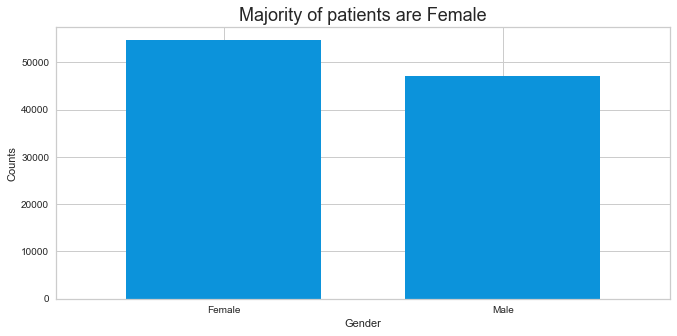

In [33]:
df['gender'].value_counts().plot(kind='bar',width=0.7,color='#0C93DB',figsize=(11,5),rot='horizontal')
plt.title('Majority of patients are Female',size=18)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.show()

#### Our goal is to predict if patient is going to be readmitted within 30 days. We will convert into 2 groups <30 days and remaining.

In [34]:
# Change all >30 and NO readmitted to NO 
df['readmitted'] = df['readmitted'].map({'NO':'NO','>30':'NO','<30':'YES'}) 

#### Targer feature 'readmitted' is very unbalanced

In [35]:
df['readmitted'].value_counts()

NO     90409
YES    11357
Name: readmitted, dtype: int64

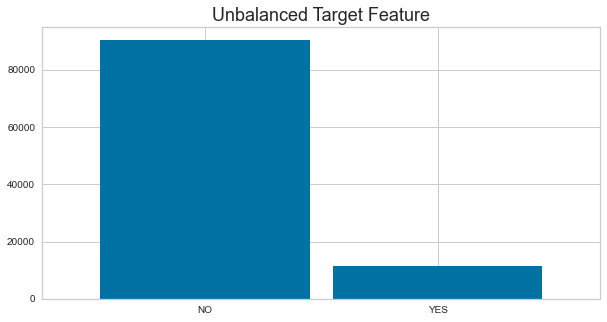

In [36]:
df['readmitted'].value_counts().plot(kind='bar',width=0.9,rot='horizontal',figsize=(10,5),color=['#17AFFD','#FD7F17']) 
plt.title('Unbalanced Target Feature',size=18)
plt.show()

<font style="color:navy;font-weight:600; font-size:18px">EDA</font>

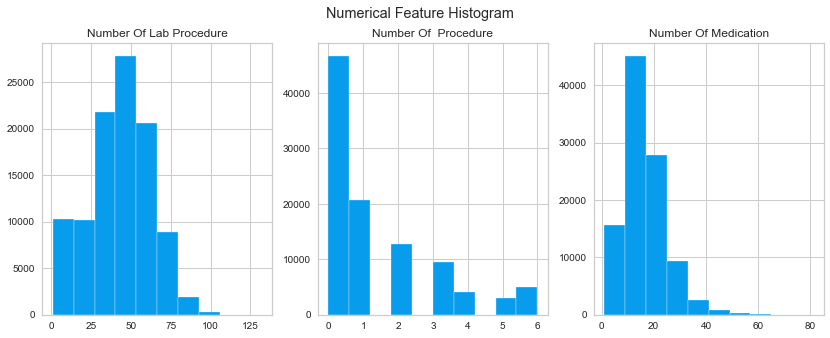

In [37]:
# Function that takes numerical data and create histogram 
fig,ax = plt.subplots(1,3,figsize=(14,5))

ax[0].hist(df['num_lab_procedures'],color='#089CEC',edgecolor='white') 
ax[0].set(title='Number Of Lab Procedure')
ax[1].hist(df['num_procedures'],color='#089CEC',edgecolor='white')
ax[1].set(title='Number Of  Procedure')
ax[2].hist(df['num_medications'],color='#089CEC',edgecolor='white')
ax[2].set(title='Number Of Medication')
plt.suptitle('Numerical Feature Histogram')
plt.show()

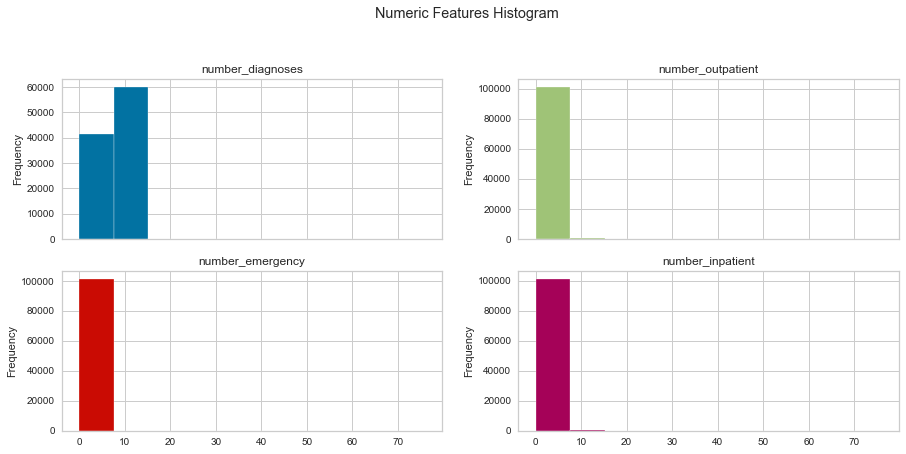

In [38]:
df.plot(kind='hist',y=['number_diagnoses','number_outpatient', 'number_emergency', 'number_inpatient'],
        edgecolor='white',figsize=[15,10],
        title=['number_diagnoses','number_outpatient', 'number_emergency', 'number_inpatient'],
        subplots=True,layout=(3,2),legend=False)
plt.suptitle('Numeric Features Histogram')
plt.show()

In [39]:
# encode target feature 
df['readmitted']=df['readmitted'].map({'YES':1,'NO':0}) 

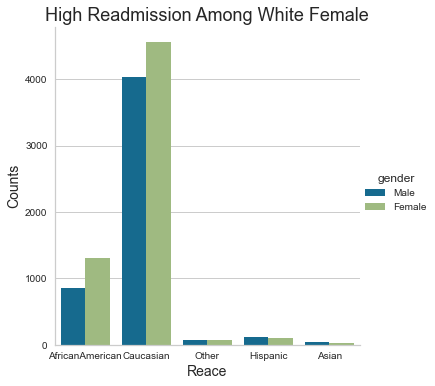

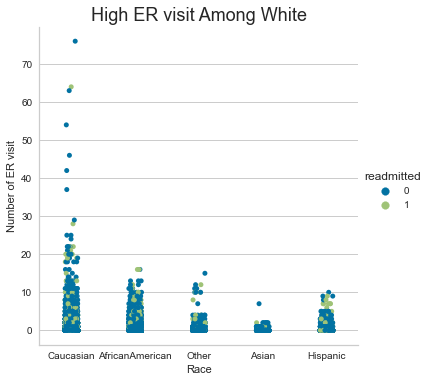

In [40]:
# Fix this plot 

# Among all the pepople who are readmitted what race and gender most likely to readmite

dat = df.loc[df['readmitted']==1,['race','gender']] 
#fig, ax = plt.subplots(1,2,figsize=(13,6))
sns.catplot(x='race',hue='gender',kind='count',data=dat,ax=ax[0])
plt.title('High Readmission Among White Female',size=18)
plt.xlabel('Reace',size=14)
plt.ylabel('Counts',size=14)
sns.catplot(x="race", y="number_emergency", hue="readmitted",  data=df,ax=ax[1])
plt.title('High ER visit Among White',size=18)
plt.xlabel('Race')
plt.ylabel('Number of ER visit')

plt.show()

In [41]:
#categorial_feature_count = len(categorical_features)
#plt.figure(figsize=(10, 6*categorial_feature_count))
#for feature in categorical_features:
#    categorical_explanatory_binary_response_chart(df, feature, 'readmitted')

### What age group people spends more time in the hospital among all readmitted patients ?

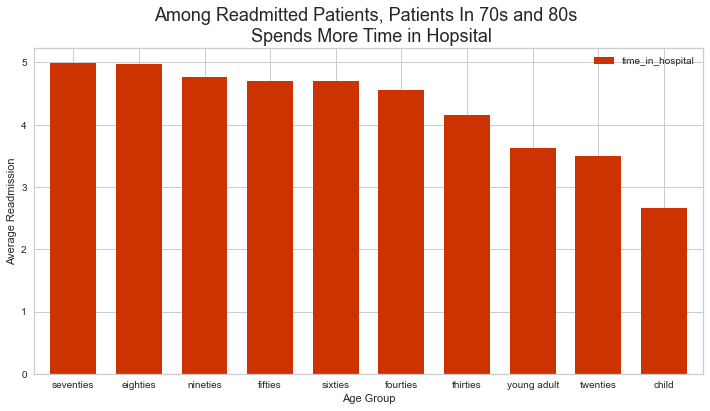

In [42]:

readmit_age= df.loc[df['readmitted']==1,['time_in_hospital','AgeGroup']].groupby(['AgeGroup']).mean()

readmit_age.sort_values(by='time_in_hospital',ascending=False).reset_index().plot(kind='bar',x='AgeGroup',
                                                                                  y='time_in_hospital',
                                                                                  figsize=(12,6),
                                                                                  width=.7,
                                                                                  rot='horizontal',
                                                                                  color='#cc3300')

plt.title('Among Readmitted Patients, Patients In 70s and 80s \n Spends More Time in Hopsital',size=18)
plt.ylabel('Average Readmission')
plt.xlabel('Age Group')
plt.show()


What is the distribution of time at hospital based on if readmission is YES or NO

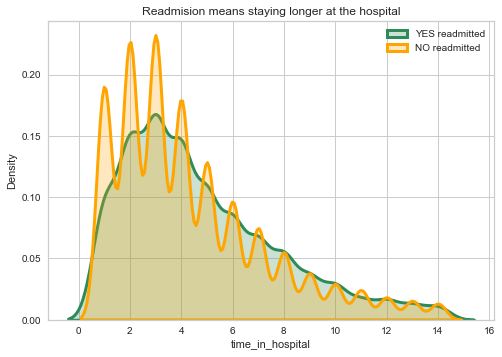

In [43]:
sns.distplot(df.loc[df['readmitted']==1,'time_in_hospital'],color='seagreen',hist=False,kde=True,
           kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "YES readmitted") 
sns.distplot(df.loc[df['readmitted']==0,'time_in_hospital'],color='orange',hist=False,kde=True,
            kde_kws={'shade':True,'linewidth':3},label='NO readmitted') 
plt.legend() 
plt.title('Readmision means staying longer at the hospital')
plt.show() 

In [44]:
df.head(5) 

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
0,Caucasian,Female,NaN,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,child,Not Mapped,Physician Referral
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,young adult,Discharged to home,Emergency Room
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,twenties,Discharged to home,Emergency Room
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,thirties,Discharged to home,Emergency Room
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,fourties,Discharged to home,Emergency Room


#### Realation Of Readmission With admission source typea and admission type

Plot on the left shows that the patients is more likely to get readmitted again in less than 30 days if they are a 
transfer patients from hospital inpt/same fac reslt in a sep claaim. 
And the plot on the right shows that if a patient is ER patients they are more than likely to readmit again in less than 30 days 

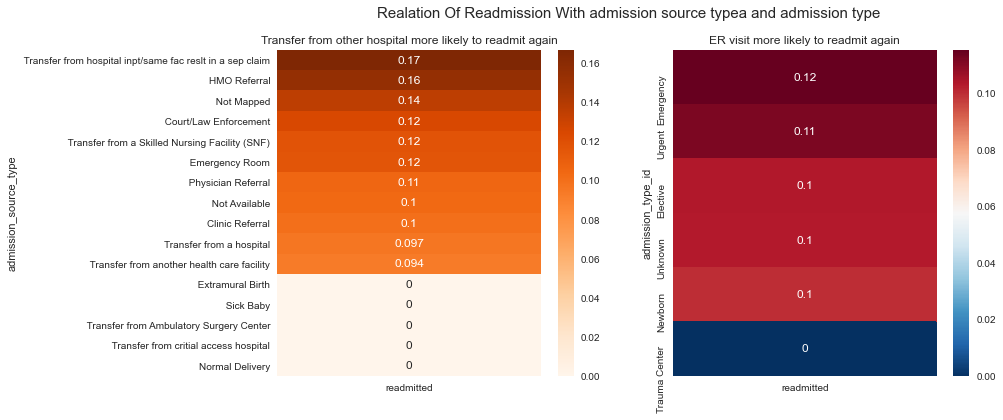

In [45]:
fig,ax = plt.subplots(1,2,figsize=(13,6))
sns.heatmap(df[['admission_source_type','readmitted']].groupby(by='admission_source_type').mean().sort_values(by='readmitted',ascending=False),annot=True,cmap='Oranges',ax=ax[0],label=False)
ax[0].set(title='Transfer from other hospital more likely to readmit again')
ax[1].set(title='ER visit more likely to readmit again')

sns.heatmap(df[['admission_type_id','readmitted']].groupby(by='admission_type_id').mean().sort_values(by='readmitted', ascending=False),annot=True,cmap='RdBu_r',ax=ax[1])
plt.suptitle('Realation Of Readmission With admission source typea and admission type',size=15)
plt.show()


Among patients who will not get readmited in less than 30 days, ***62.67%*** were discharged to their home 

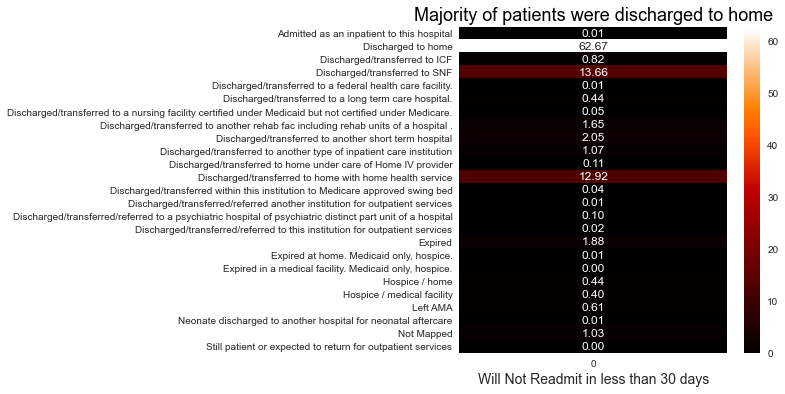

In [46]:
df_discharge = df.loc[df['readmitted']==0,['discharge_disposition_type','readmitted']]

ct = pd.crosstab(df_discharge['discharge_disposition_type'], 
                 df_discharge['readmitted'],
                    normalize=True ).round(4)*100 

plt.figure(figsize=(6,6))
discharge_readmit = sns.cubehelix_palette(start=0,light=1,as_cmap=True)
sns.heatmap(ct,annot=True,cmap='gist_heat',fmt='.2f',linewidths=.0)
plt.xlabel('Will Not Readmit in less than 30 days',size=14)
plt.ylabel('',size=14)
plt.title('Majority of patients were discharged to home',fontsize=18,color='black')
plt.show()

#### Correlation of numerical features 

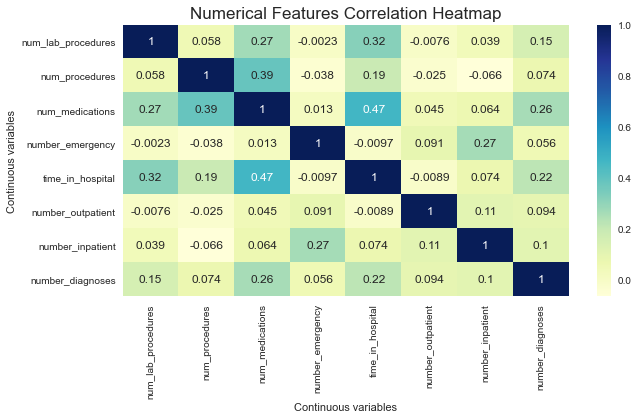

In [47]:
plt.figure(figsize=(10,5))
corr=df[['num_lab_procedures','num_procedures','num_medications','number_emergency','time_in_hospital','number_outpatient','number_inpatient','number_diagnoses']].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.title("Correlation matrix", y=-0.75)
plt.xlabel("Continuous variables")
plt.ylabel("Continuous variables")
plt.title('Numerical Features Correlation Heatmap',size=17)
plt.show()


In [48]:
corr=df[['num_lab_procedures','num_procedures','num_medications','number_emergency','time_in_hospital','number_outpatient','number_inpatient','number_diagnoses']]
#sns.pairplot(data=corr, hue="readmitted")


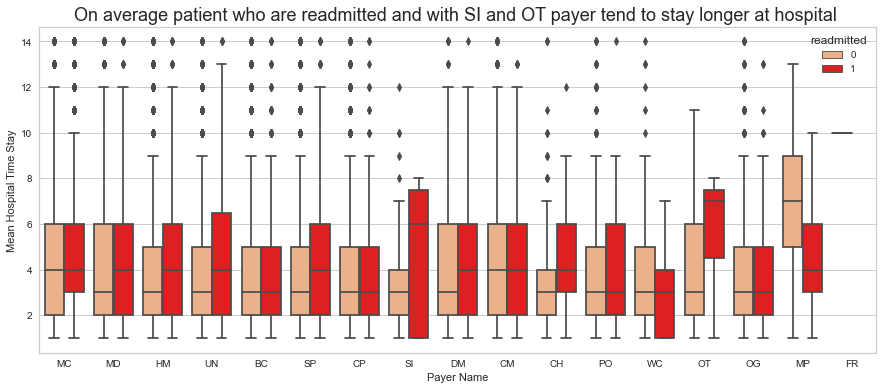

In [49]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['payer_code'],y=df['time_in_hospital'],hue=df['readmitted'],palette=["#FAAE7B",'red'])
plt.xlabel('Payer Name')
plt.ylabel('Mean Hospital Time Stay')
plt.title('On average patient who are readmitted and with SI and OT payer tend to stay longer at hospital ',size=18)
plt.show()

#### Working with ICD9 code. Grouping Diagnostic columns with ICD-9-CM Chapters Code Range
###### Ref:https://icd.codes/icd9cm

In [51]:
#Create custom code range feature for diag_1, diag_2, diag_3 columns
groupDiagnosticColumns(df, 'diag_1')
groupDiagnosticColumns(df, 'diag_2')
groupDiagnosticColumns(df, 'diag_3')

In [52]:
df.head()

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type,diag_1_Cat,diag_2_Cat,diag_3_Cat
0,Caucasian,Female,NaN,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,child,Not Mapped,Physician Referral,240-279,NaN,NaN
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276.00,250.01,255.0,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,young adult,Discharged to home,Emergency Room,240-279,240-279,240-279
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648.00,250.00,100027.0,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,twenties,Discharged to home,Emergency Room,630-679,240-279,V01-V91
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8.00,250.43,403.0,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,thirties,Discharged to home,Emergency Room,001-139,240-279,390-459
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197.00,157.00,250.0,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,fourties,Discharged to home,Emergency Room,140-239,140-239,240-279


##### Dropping diag_1, diag_2, diag_3 as we have created range features

In [53]:
# Drop unnecessary columns 
df = df.drop(['diag_1','diag_2','diag_3'],axis=1)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   race                        99493 non-null   object  
 1   gender                      101766 non-null  object  
 2   admission_type_id           96155 non-null   object  
 3   time_in_hospital            101766 non-null  int64   
 4   payer_code                  61510 non-null   object  
 5   medical_specialty           51817 non-null   object  
 6   num_lab_procedures          101766 non-null  int64   
 7   num_procedures              101766 non-null  int64   
 8   num_medications             101766 non-null  int64   
 9   number_outpatient           101766 non-null  int64   
 10  number_emergency            101766 non-null  int64   
 11  number_inpatient            101766 non-null  int64   
 12  number_diagnoses            101766 non-null  int64   
 13 

##### Imputing missing data 

In [55]:
df = grouper_impute(df)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   race                        101766 non-null  object  
 1   gender                      101766 non-null  object  
 2   admission_type_id           101766 non-null  object  
 3   time_in_hospital            101766 non-null  int64   
 4   payer_code                  101766 non-null  object  
 5   medical_specialty           101766 non-null  object  
 6   num_lab_procedures          101766 non-null  int64   
 7   num_procedures              101766 non-null  int64   
 8   num_medications             101766 non-null  int64   
 9   number_outpatient           101766 non-null  int64   
 10  number_emergency            101766 non-null  int64   
 11  number_inpatient            101766 non-null  int64   
 12  number_diagnoses            101766 non-null  int64   
 13 

In [57]:
df.isna().sum()/df.shape[0]*100

race                          0.0
gender                        0.0
admission_type_id             0.0
time_in_hospital              0.0
payer_code                    0.0
medical_specialty             0.0
num_lab_procedures            0.0
num_procedures                0.0
num_medications               0.0
number_outpatient             0.0
number_emergency              0.0
number_inpatient              0.0
number_diagnoses              0.0
max_glu_serum                 0.0
A1Cresult                     0.0
metformin                     0.0
repaglinide                   0.0
nateglinide                   0.0
chlorpropamide                0.0
glimepiride                   0.0
acetohexamide                 0.0
glipizide                     0.0
glyburide                     0.0
tolbutamide                   0.0
pioglitazone                  0.0
rosiglitazone                 0.0
acarbose                      0.0
miglitol                      0.0
troglitazone                  0.0
tolazamide    

In [58]:
features_of_interest_encoding =['race', 'gender', 'admission_type_id', 'payer_code',
       'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetic_medication_change', 
       'diabetesMed', 'AgeGroup', 'discharge_disposition_type',
       'admission_source_type', 'diag_1_Cat', 'diag_2_Cat', 'diag_3_Cat']
print(features_of_interest_encoding)

['race', 'gender', 'admission_type_id', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetic_medication_change', 'diabetesMed', 'AgeGroup', 'discharge_disposition_type', 'admission_source_type', 'diag_1_Cat', 'diag_2_Cat', 'diag_3_Cat']


#### categorical explanatory binary response chart

              race          1  count
0        Caucasian  11.202981  78372
1  AfricanAmerican  11.218116  19210
2         Hispanic  10.407462   2037
3            Other   9.628154   1506
4            Asian  10.140406    641


<Figure size 720x16416 with 0 Axes>

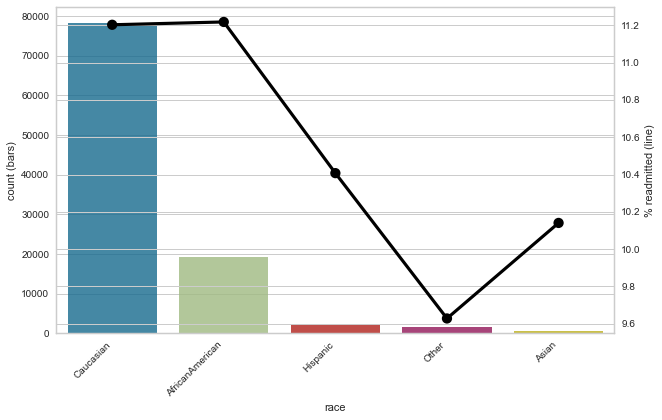

   gender          1  count
0  Female  11.244539  54711
1    Male  11.061524  47055


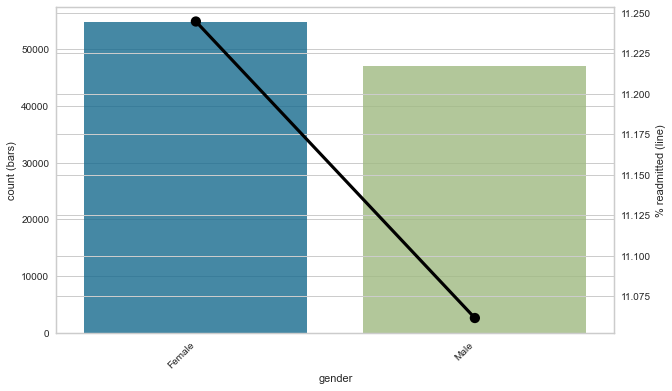

  admission_type_id          1  count
0         Emergency  11.466251  59601
1          Elective  10.392708  18869
2            Urgent  11.179654  18480
3           Unknown  10.344828   4785
4     Trauma Center   0.000000     21
5           Newborn  10.000000     10


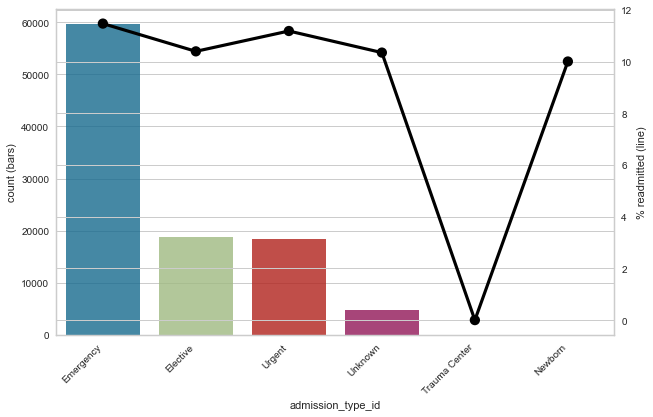

   payer_code          1  count
0          MC  11.657760  69799
1          HM  10.606442   7948
2          SP  10.185740   5007
3          BC   8.933778   4802
4          MD  11.156935   4607
5          CP   8.448480   2533
6          UN   9.272876   2448
7          CM  10.221993   1937
8          OG  13.165537   1033
9          PO   7.432432    592
10         DM  11.657559    549
11         CH   8.904110    146
12         WC   3.703704    135
13         OT   7.368421     95
14         MP  11.392405     79
15         SI  12.727273     55
16         FR   0.000000      1


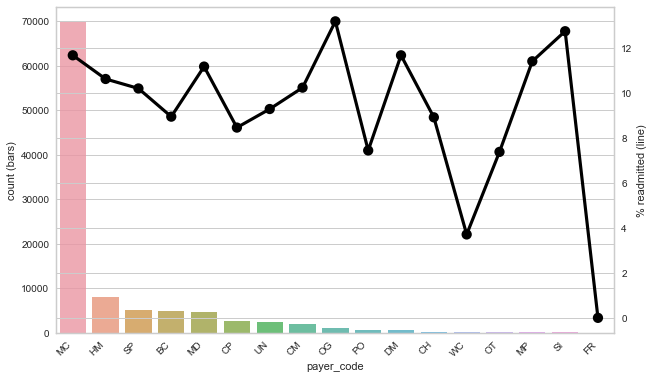

                   medical_specialty          1  count
0                   InternalMedicine  11.509762  64328
1                   Emergency/Trauma  11.183080   7565
2             Family/GeneralPractice  11.868280   7440
3                         Cardiology   7.940957   5352
4                    Surgery-General  11.035818   3099
..                               ...        ...    ...
67                       Dermatology   0.000000      1
68  Surgery-PlasticwithinHeadandNeck   0.000000      1
69                        Proctology   0.000000      1
70              Psychiatry-Addictive   0.000000      1
71                    SportsMedicine   0.000000      1

[72 rows x 3 columns]


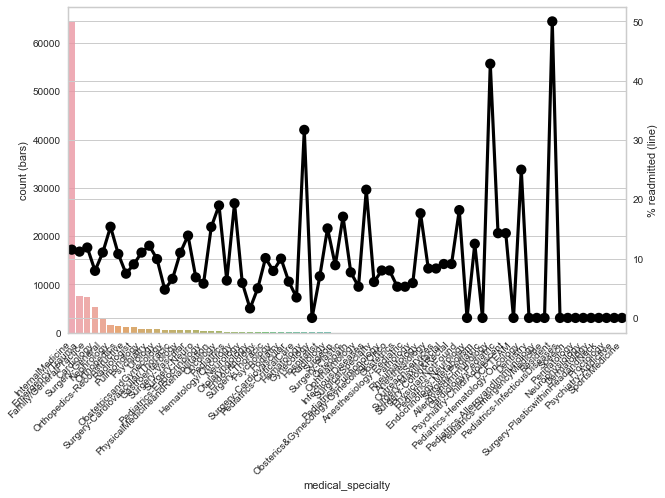

   max_glu_serum          1  count
0        unknown  11.093134  96420
1         Normal  11.359261   2597
2       diabetic  12.457912   1485
3  critical high  14.319620   1264


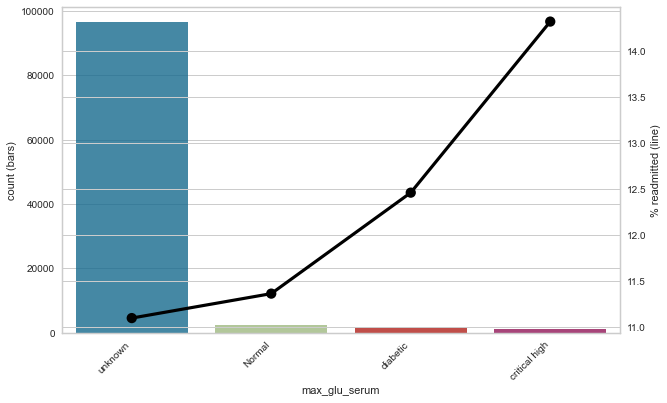

               A1Cresult          1  count
0                Unknown  11.423278  84748
1          critical high   9.870983   8216
2                 Normal   9.659319   4990
3  uncontrolled diabetes  10.047219   3812


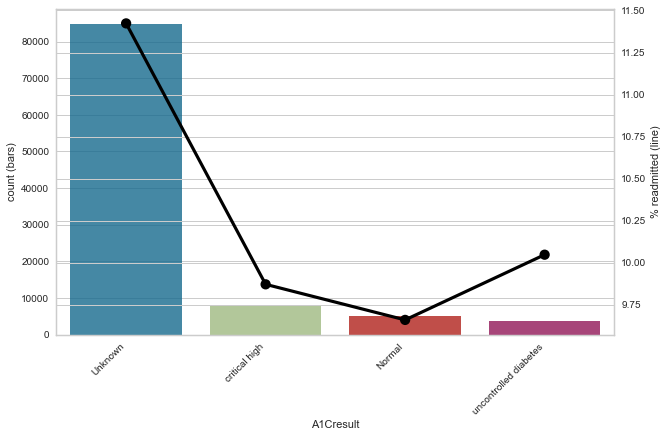

  metformin          1  count
0        No  11.516545  81778
1    Steady   9.713289  18346
2        Up   8.247423   1067
3      Down  12.000000    575


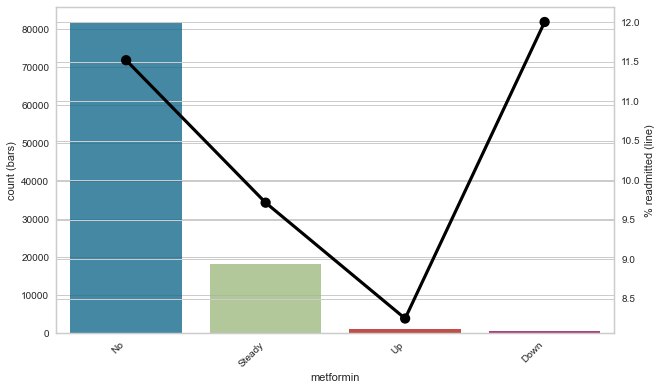

  repaglinide          1   count
0          No  11.126742  100227
1      Steady  13.150289    1384
2          Up  18.181818     110
3        Down   6.666667      45


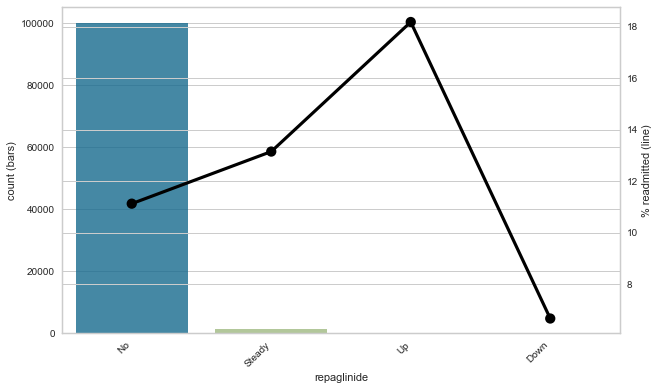

  nateglinide          1   count
0          No  11.158386  101063
1      Steady  11.676647     668
2          Up   4.166667      24
3        Down   9.090909      11


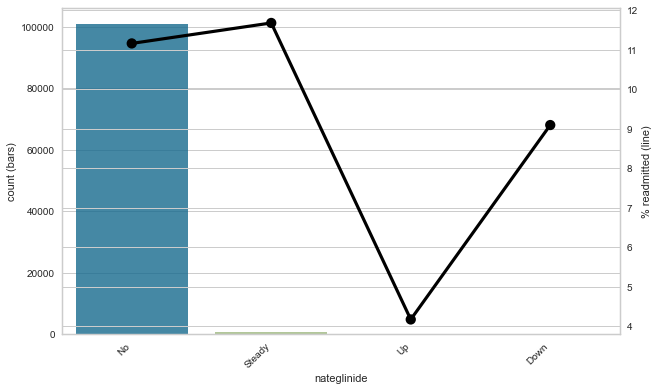

  chlorpropamide          1   count
0             No  11.164437  101680
1         Steady   6.329114      79
2             Up   0.000000       6
3           Down   0.000000       1


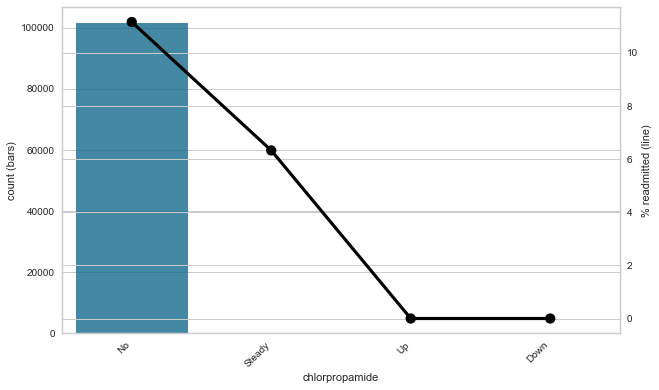

  glimepiride          1  count
0          No  11.210976  96575
1      Steady  10.021413   4670
2          Up  11.314985    327
3        Down  12.886598    194


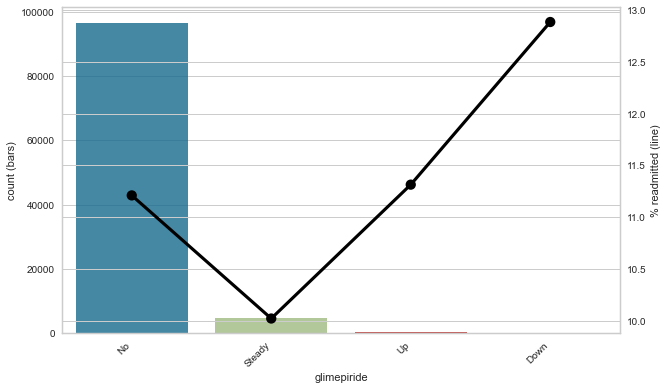

  acetohexamide          1   count
0            No  11.160026  101765
1        Steady   0.000000       1


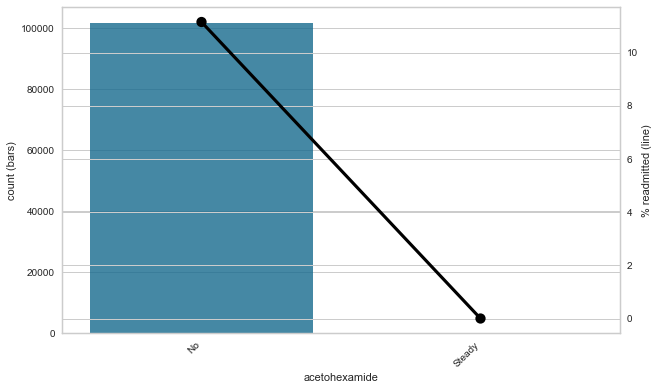

  glipizide          1  count
0        No  11.119219  89080
1    Steady  11.165903  11356
2        Up  12.857143    770
3      Down  15.178571    560


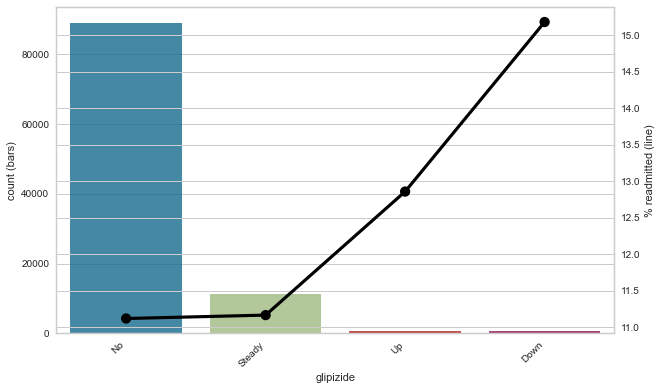

  glyburide          1  count
0        No  11.221959  91116
1    Steady  10.728920   9274
2        Up  10.467980    812
3      Down   9.219858    564


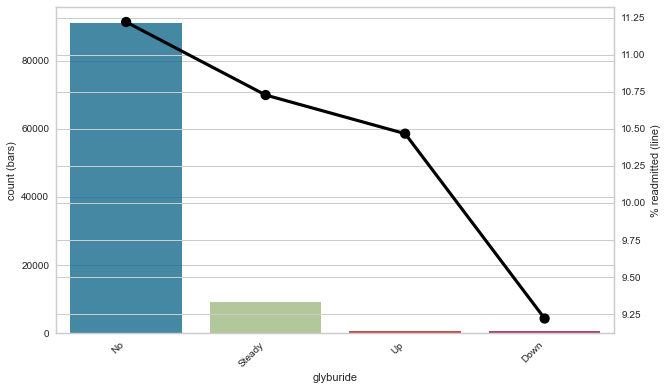

  tolbutamide          1   count
0          No  11.161456  101743
1      Steady   4.347826      23


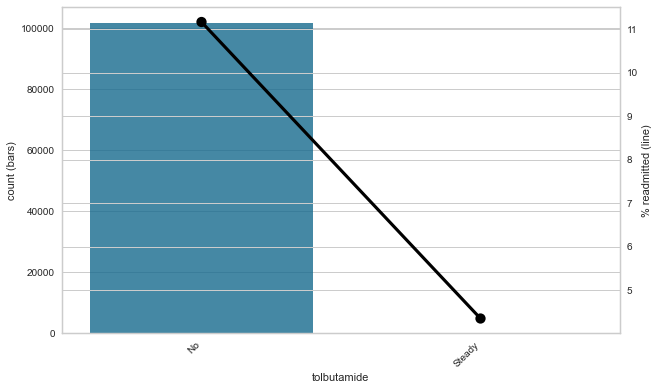

  pioglitazone          1  count
0           No  11.206294  94438
1       Steady  10.421445   6976
2           Up  12.393162    234
3         Down  15.254237    118


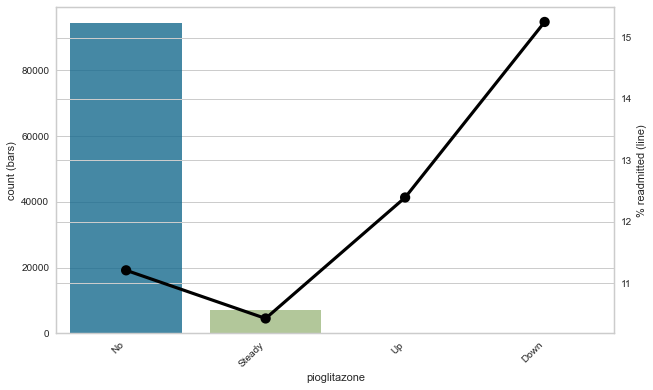

  rosiglitazone          1  count
0            No  11.207430  95401
1        Steady  10.508197   6100
2            Up  10.674157    178
3          Down   5.747126     87


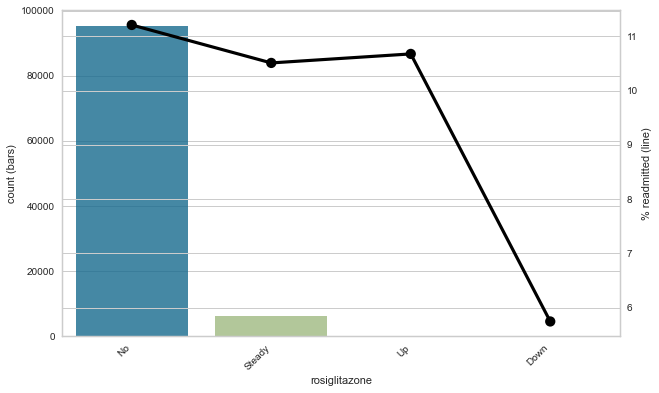

  acarbose          1   count
0       No  11.166197  101458
1   Steady   8.474576     295
2       Up  20.000000      10
3     Down  33.333333       3


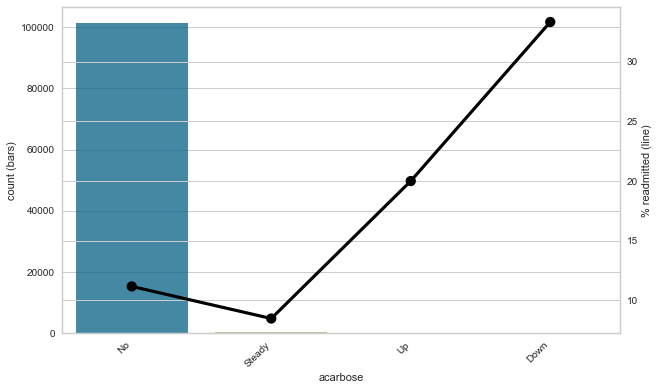

  miglitol          1   count
0       No  11.160153  101728
1   Steady   6.451613      31
2     Down  40.000000       5
3       Up   0.000000       2


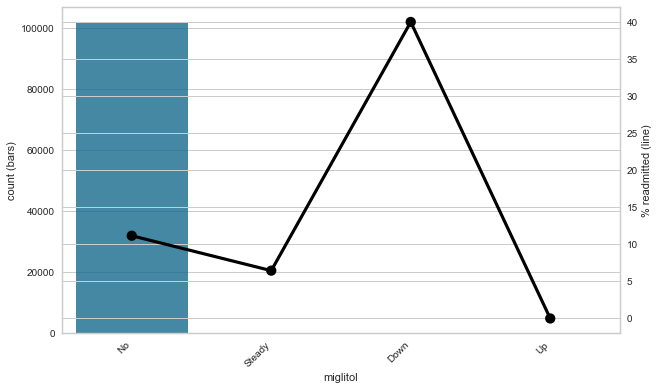

  troglitazone          1   count
0           No  11.160245  101763
1       Steady   0.000000       3


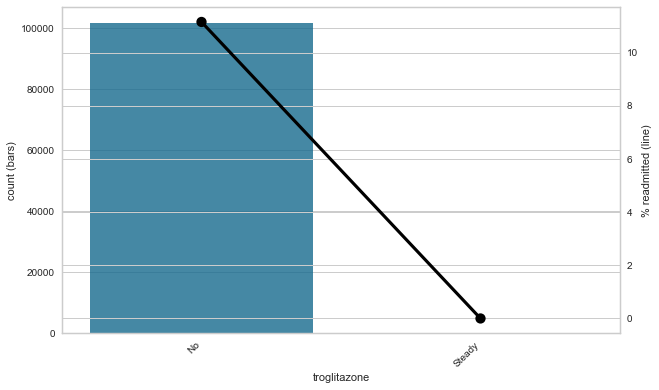

  tolazamide          1   count
0         No  11.161245  101727
1     Steady   7.894737      38
2         Up   0.000000       1


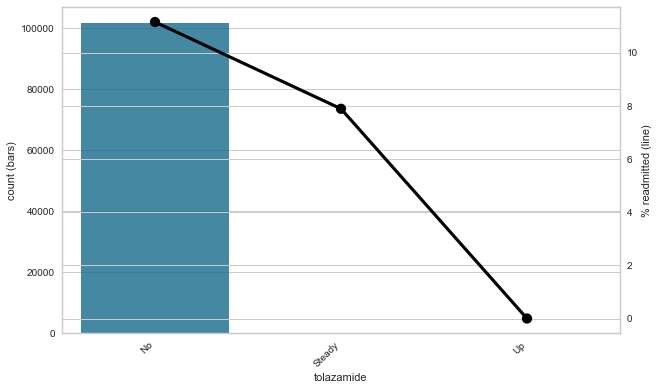

  examide          1   count
0      No  11.159916  101766


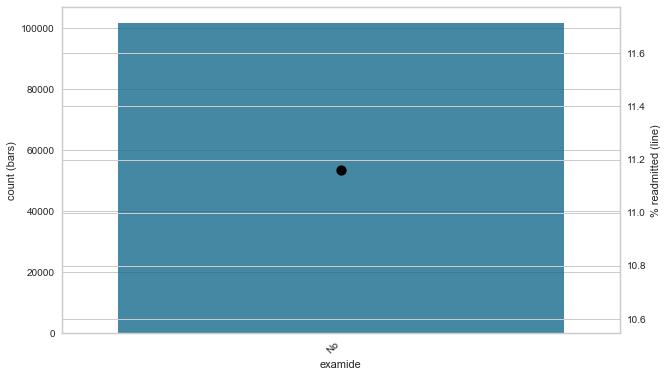

  citoglipton          1   count
0          No  11.159916  101766


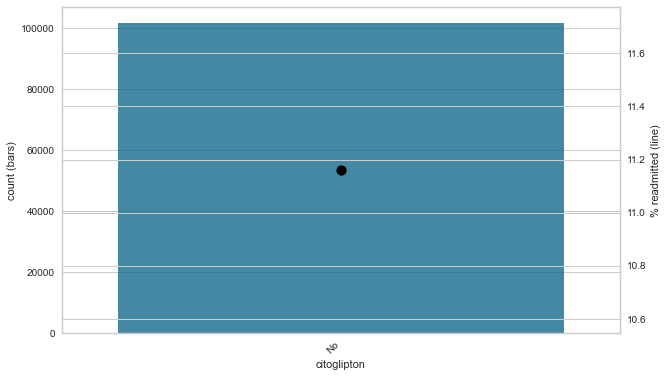

  insulin          1  count
0      No  10.037355  47383
1  Steady  11.128400  30849
2    Down  13.897528  12218
3      Up  12.990456  11316


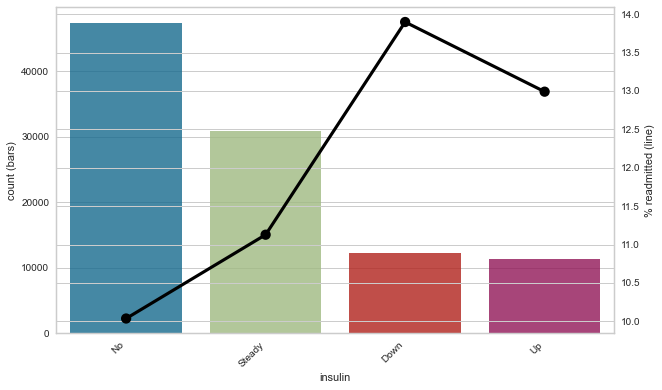

  glyburide-metformin          1   count
0                  No  11.160697  101060
1              Steady  11.127168     692
2                  Up   0.000000       8
3                Down  16.666667       6


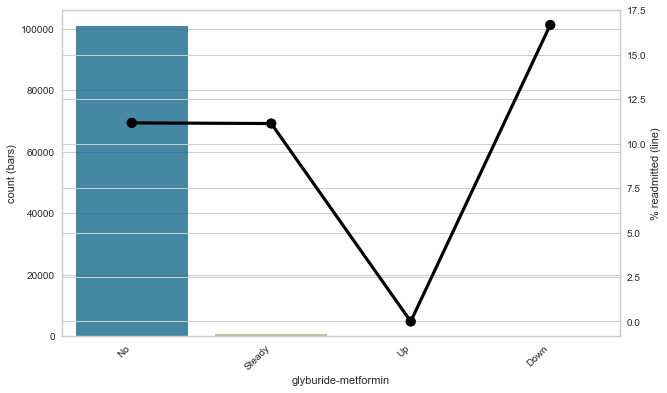

  glipizide-metformin          1   count
0                  No  11.160359  101753
1              Steady   7.692308      13


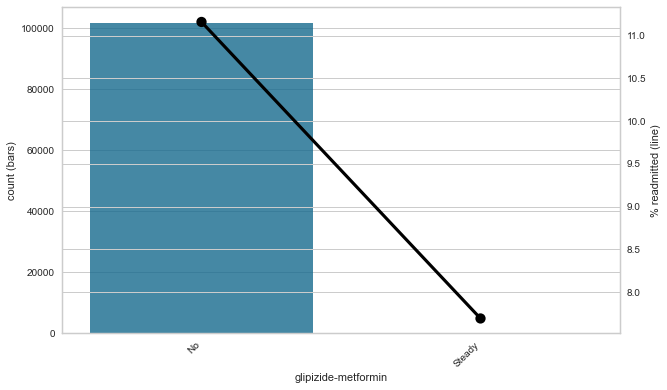

  glimepiride-pioglitazone          1   count
0                       No  11.160026  101765
1                   Steady   0.000000       1


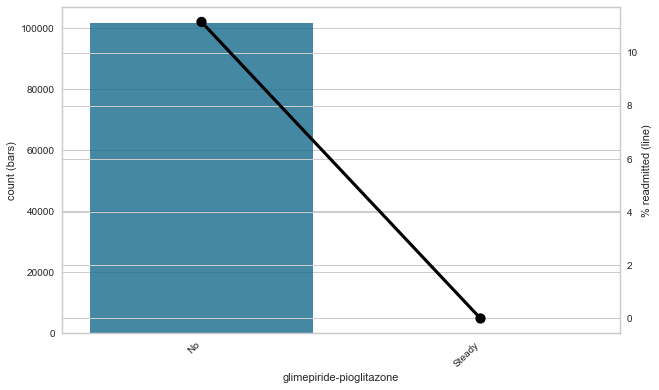

  metformin-rosiglitazone          1   count
0                      No  11.160135  101764
1                  Steady   0.000000       2


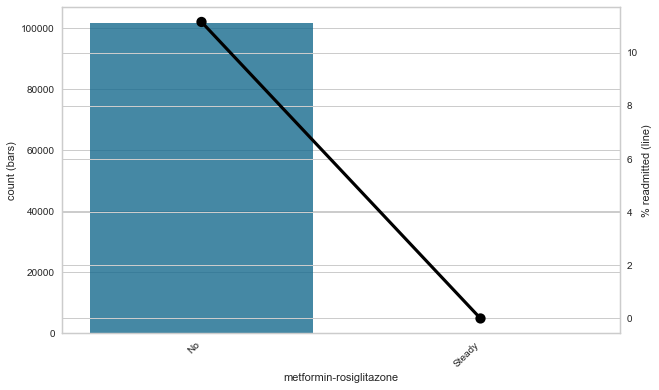

  metformin-pioglitazone          1   count
0                     No  11.160026  101765
1                 Steady   0.000000       1


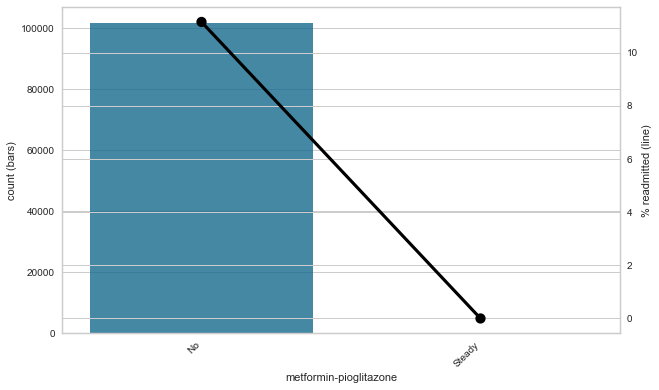

  diabetic_medication_change          1  count
0                         No  10.590814  54755
1                         Ch  11.822765  47011


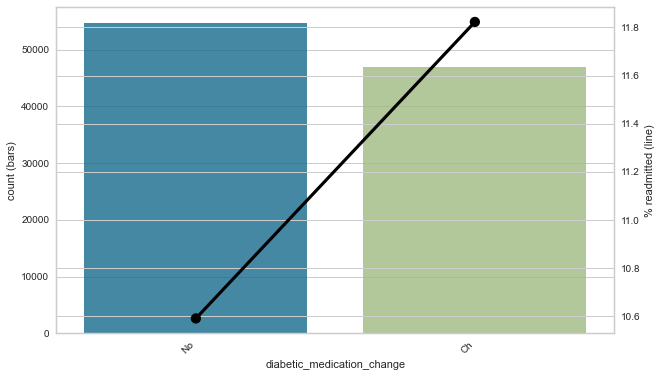

  diabetesMed          1  count
0         Yes  11.626661  78363
1          No   9.597060  23403


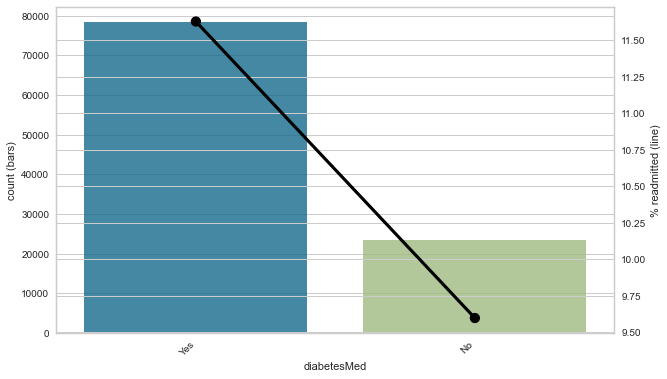

      AgeGroup          1  count
0    seventies  11.773055  26068
1      sixties  11.128408  22483
2      fifties   9.666203  17256
3     eighties  12.083503  17197
4     fourties  10.604027   9685
5     thirties  11.231788   3775
6     nineties  11.099177   2793
7     twenties  14.242607   1657
8  young adult   5.788712    691
9        child   1.863354    161


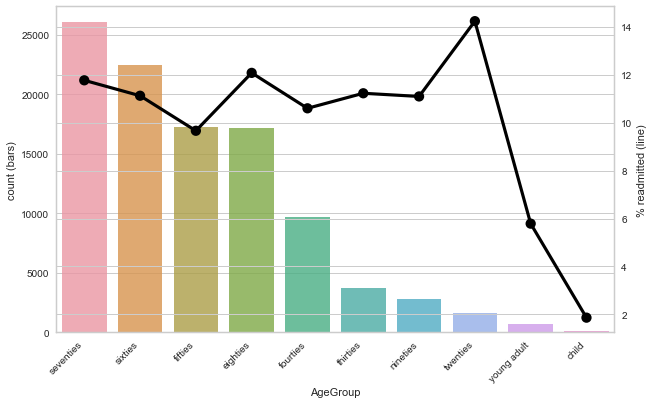

                           discharge_disposition_type          1  count
0                                  Discharged to home   9.474376  63867
1                       Discharged/transferred to SNF  14.673137  14012
2   Discharged/transferred to home with home healt...  12.695706  12902
3   Discharged/transferred to another short term h...  16.071429   2128
4   Discharged/transferred to another rehab fac in...  27.696939   1993
5                                             Expired   0.000000   1642
6   Discharged/transferred to another type of inpa...  20.861486   1184
7                                          Not Mapped   9.302326    989
8                       Discharged/transferred to ICF  12.760736    815
9                                            Left AMA  14.446228    623
10  Discharged/transferred to a long term care hos...   7.281553    412
11                                     Hospice / home   4.761905    399
12                         Hospice / medical facility   6.451613

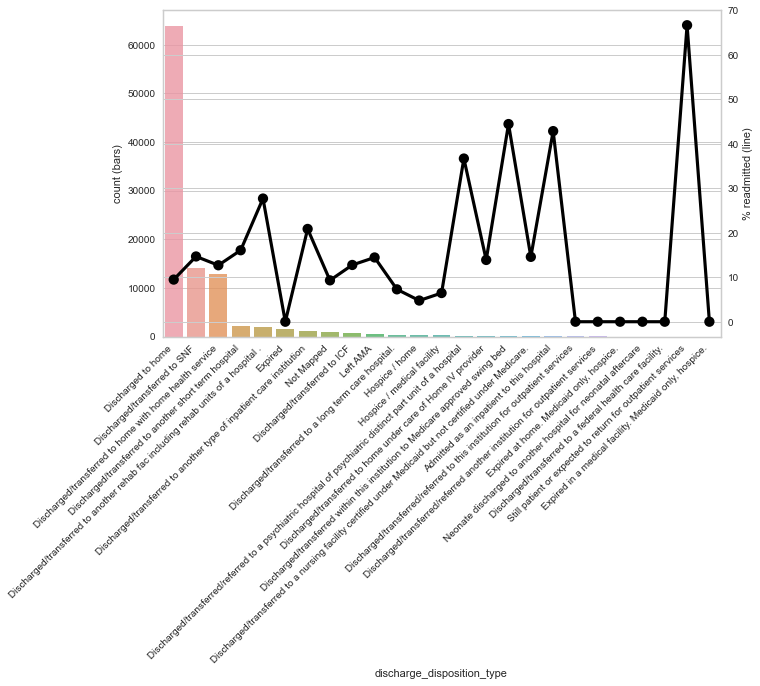

                                admission_source_type          1  count
0                                      Emergency Room  11.553481  64275
1                                  Physician Referral  10.586843  29565
2                            Transfer from a hospital   9.695639   3187
3          Transfer from another health care facility   9.363958   2264
4                                     Clinic Referral  10.054348   1104
5      Transfer from a Skilled Nursing Facility (SNF)  11.812865    855
6                                        HMO Referral  15.508021    187
7                                          Not Mapped  13.664596    161
8                                       Not Available  10.400000    125
9                               Court/Law Enforcement  12.500000     16
10   Transfer from hospital inpt/same fac reslt in...  16.666667     12
11              Transfer from critial access hospital   0.000000      8
12                                   Extramural Birth   0.000000

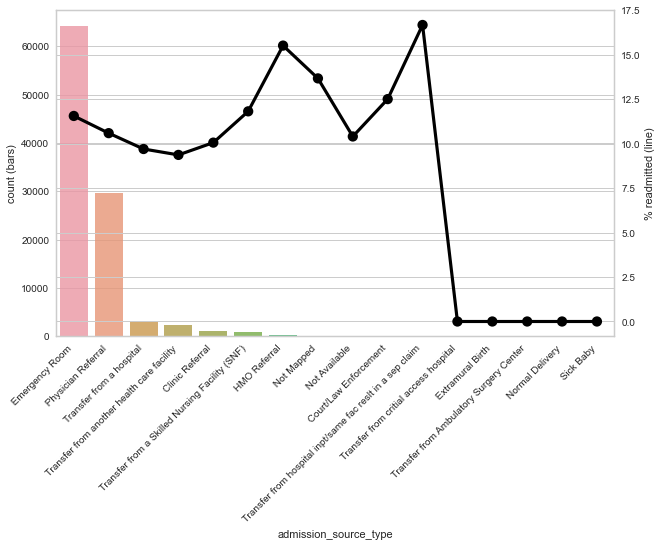

   diag_1_Cat          1  count
0     390-459  11.460667  30356
1     240-279  12.783595  11460
2     460-519  10.685116  10407
3     520-579  10.490877   9208
4     780-799   8.996857   7636
5     800-999  12.245483   6974
6     580-629  10.811343   5078
7     710-739   9.501715   4957
8     140-239  10.078648   3433
9     001-139  11.452312   2768
10    680-709   9.881423   2530
11    290-319  12.201592   2262
12    V01-V91  16.180049   1644
13    320-389  10.322048   1211
14    280-289  13.417951   1103
15    630-679   6.113537    687
16    740-759   7.843137     51
17  E000-E999   0.000000      1


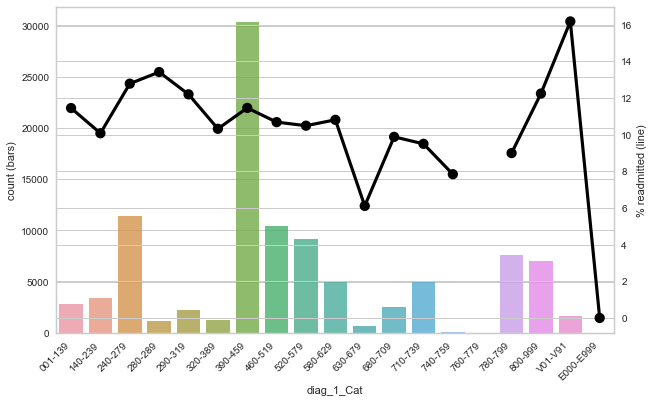

   diag_2_Cat          1  count
0     390-459  11.040218  31503
1     240-279  10.773650  21237
2     460-519  10.711150  10251
3     580-629  11.856767   7987
4     780-799  10.600173   4632
5     520-579  11.585058   3962
6     680-709  13.654060   3596
7     280-289   9.603554   2926
8     290-319  10.876929   2657
9     140-239  14.919513   2547
10    800-999  11.449753   2428
11    001-139  12.014500   1931
12    V01-V91  10.083102   1805
13    710-739  10.034014   1764
14    320-389  12.519440   1286
15  E000-E999  13.543092    731
16    630-679   4.096386    415
17    740-759   8.333333    108


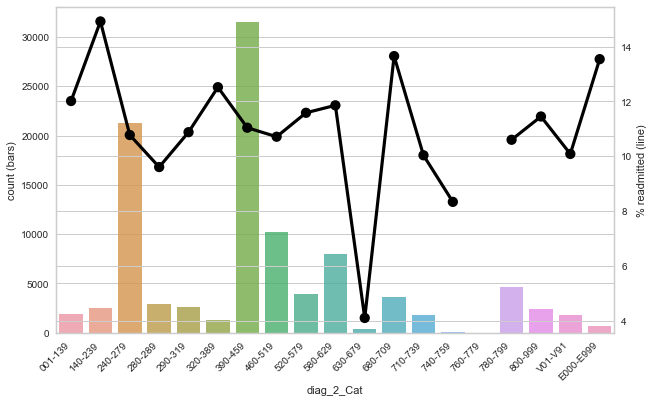

   diag_3_Cat          1  count
0     390-459  10.669877  30319
1     240-279  10.274424  27330
2     460-519  12.208444   6774
3     580-629  13.592540   6327
4     780-799  12.226398   4523
5     V01-V91   9.989512   3814
6     520-579  12.290034   3572
7     290-319  11.383929   3136
8     280-289  11.485944   2490
9     680-709  13.665595   2488
10    800-999  11.562179   1946
11    710-739  10.652742   1915
12    001-139  11.176787   1861
13    140-239  14.224138   1856
14    320-389  11.947905   1766
15  E000-E999  11.173633   1244
16    630-679   3.559871    309
17    740-759   9.375000     96


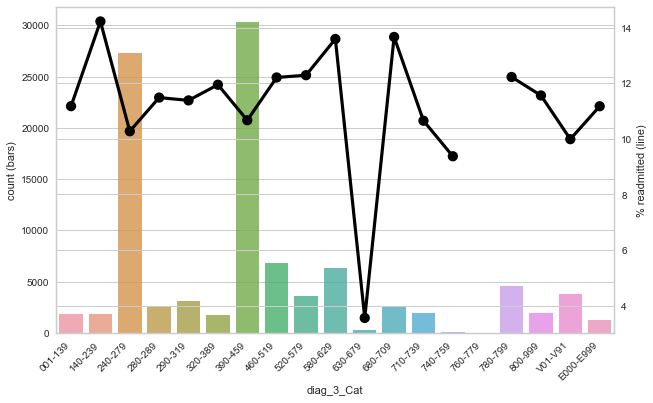

In [59]:
categorial_feature_count = len(features_of_interest_encoding)
plt.figure(figsize=(10, 6*categorial_feature_count))
for feature in features_of_interest_encoding:
    categorical_explanatory_binary_response_chart(df, feature, 'readmitted')

#### These are the features which we want to dummy code

In [60]:
features_of_interest_encoding

['race',
 'gender',
 'admission_type_id',
 'payer_code',
 'medical_specialty',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'diabetic_medication_change',
 'diabetesMed',
 'AgeGroup',
 'discharge_disposition_type',
 'admission_source_type',
 'diag_1_Cat',
 'diag_2_Cat',
 'diag_3_Cat']

#### Dummy Code Variables 

In [61]:
df_dummy_enc = create_dummy_encod(df, features_of_interest_encoding, drop_first_cat=True, sparsity=True)

In [62]:
df_dummy_enc.shape

(101766, 264)

In [63]:
df_dummy_enc.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_Emergency,admission_type_id_Newborn,admission_type_id_Trauma Center,admission_type_id_Unknown,admission_type_id_Urgent,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,medical_specialty_Anesthesiology,medical_specialty_Anesthesiology-Pediatric,medical_specialty_Cardiology,medical_specialty_Cardiology-Pediatric,medical_specialty_DCPTEAM,medical_specialty_Dentistry,medical_specialty_Dermatology,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Endocrinology-Metabolism,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology,medical_specialty_Hematology/Oncology,medical_specialty_Hospitalist,medical_specialty_InfectiousDiseases,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Neurophysiology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_Obstetrics,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Ophthalmology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Osteopath,medical_specialty_Otolaryngology,medical_specialty_OutreachServices,medical_specialty_Pathology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-AllergyandImmunology,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-EmergencyMedicine,medical_specialty_Pediatrics-Endocrinology,medical_specialty_Pediatrics-Hematology-Oncology,medical_specialty_Pediatrics-InfectiousDiseases,medical_specialty_Pediatrics-Neurology,medical_specialty_Pediatrics-Pulmonology,medical_specialty_Perinatology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_PhysicianNotFound,medical_specialty_Podiatry,medical_specialty_Proctology,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Addictive,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiologist,medical_specialty_Radiology,medical_specialty_Resident,medical_specialty_Rheumatology,medical_specialty_Speech,medical_specialty_SportsMedicine,medical_specialty_Surgeon,medical_specialty_Surgery-Cardiovascular,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-Colon&Rectal,medical_specialty_Surgery-General,medical_specialty_Surgery-Maxillofacial,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Pediatric,medical_specialty_Surgery-Plastic,medical_specialty_Surgery-PlasticwithinHeadandNeck,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,max_glu_serum_critical high,max_glu_serum_diabetic,max_glu_serum_unknown,A1Cresult_Unknown,A1Cresult_critical high,A1Cresult_uncontrolled diabetes,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglit

#### Get the final dataset ready to model 

#### Split datasets into training and testing 

In [64]:
y = df_dummy_enc['readmitted']
X = df_dummy_enc.drop(columns = ['readmitted'], axis = 1)

<br>

In [65]:
# Break our data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234, stratify=y)

### Logistic Regression Iteration 1 - Unscaled Data¶

We will use 5-fold cross validation to determine a baseline accuracy score for logistic regression.

In [66]:
#https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb
cv = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
model = linear_model.LogisticRegression(solver='lbfgs', random_state=1234, max_iter = 1e3)
stratified_cross_validate(model, X_train, y_train, cv=cv)

Fold Scores:
 
[0.8882884  0.8878585  0.88809729 0.88785162 0.88877288]
 
Mean Accuracy:  0.8881737360655733
Mean Fit Time:  55.18134274482727
Mean Score Time:  0.0834078311920166
CV Time:  59.680981159210205


<font style="color:#7B1FA2;font-weight:600">We will use 88.80 % as our baseline accuracy for logistic regression. Let's see how scaling the data can help increase our accuracy.</font>

#### Let us fit the predict the accuracy of the model

In [67]:
model.fit(X_train, y_train)
y_model_predict = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_predict)
print('Accuracy of "Logistic Regression Iteration 1 - Unscaled Data": ', accuracy)

Accuracy of "Logistic Regression Iteration 1 - Unscaled Data":  0.8877861845337526


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 1 - unscaled Data is 88.77 % </font>

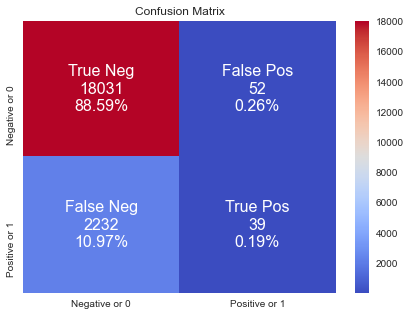

In [68]:
plot_confusion_matrix(y_test, y_model_predict)

LR ROC: 0.5071487112376506


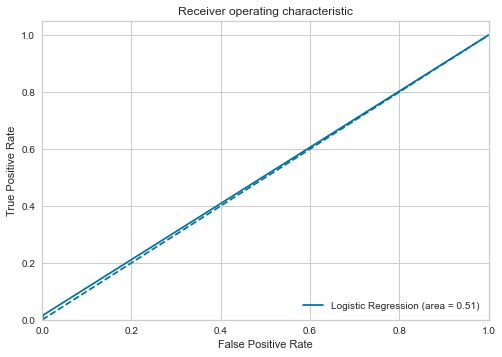

In [69]:
plot_roc_curve(y_test, y_model_predict)

<br/><br/>

### Logistic Regression Iteration 2 - Scaled data

In [70]:
#Scaling the features will likely make a big improvement to accuaracy 
#Scaling the entire data before split for cross validation
std_scalar = preprocessing.StandardScaler()
X_scaled = std_scalar.fit_transform(X)

# Resetting the split data after scaling
# Break our data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=1234, stratify=y)

#### Next, we will run the model using 5-fold cross validation on scaled data.

In [71]:
cv_scaled = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
model_scaled = linear_model.LogisticRegression(solver='lbfgs', random_state=1234, max_iter = 1e3)
stratified_cross_validate(model_scaled, X_train, y_train, cv=cv_scaled)

Fold Scores:
 
[0.88822699 0.88755143 0.88791303 0.8877902  0.88858863]
 
Mean Accuracy:  0.8880140550495123
Mean Fit Time:  10.947160387039185
Mean Score Time:  0.013401556015014648
CV Time:  13.347882986068726


<font style="color:#7B1FA2;font-weight:600">Accuracy remain same but Fit time decreased from 55.15 seconds to 11 seconds, Score time reduced from 0.020 to 0.015  and CV time decreased from 56 seconds to 15 seconds.</font>

In [72]:
model_scaled.fit(X_train, y_train)
y_model_scaled_predict = model_scaled.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_scaled_predict)
print('Accuracy of "Logistic Regression Iteration 2 - scaled Data": ', accuracy)

Accuracy of "Logistic Regression Iteration 2 - scaled Data":  0.887737054141692


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 2 - scaled Data is 88.77 % </font>

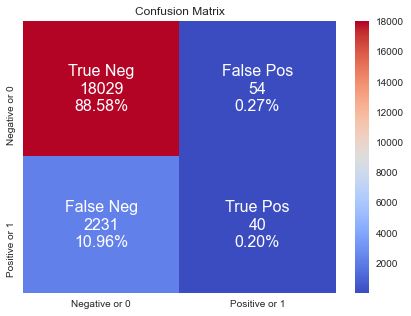

In [73]:
plot_confusion_matrix(y_test, y_model_scaled_predict)

LR ROC: 0.5073135780062836


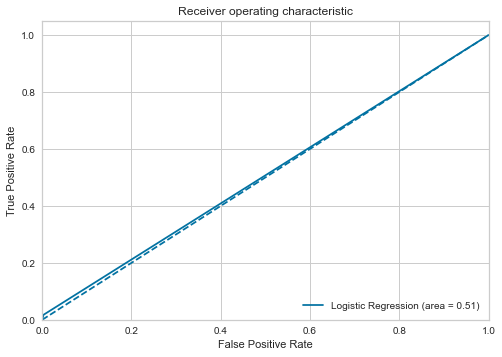

In [74]:
plot_roc_curve(y_test, y_model_scaled_predict)

<br/><br/>

### Logistic Regression L1 Feature Importance on scaled data 

In [149]:
#Logistic Regression L1 Feature Importance¶
CV = model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
clf = linear_model.LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',C=0.05)
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=CV)
print('5 fold cross validation accuracy:',scores)
print('Mean Accuracy is : ',scores.mean())

5 fold cross validation accuracy: [0.67168212 0.66873426 0.6696966  0.66797691 0.66576588]
Mean Accuracy is :  0.6687711532196882


In [150]:
clf.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight='balanced', penalty='l1',
                   solver='liblinear')

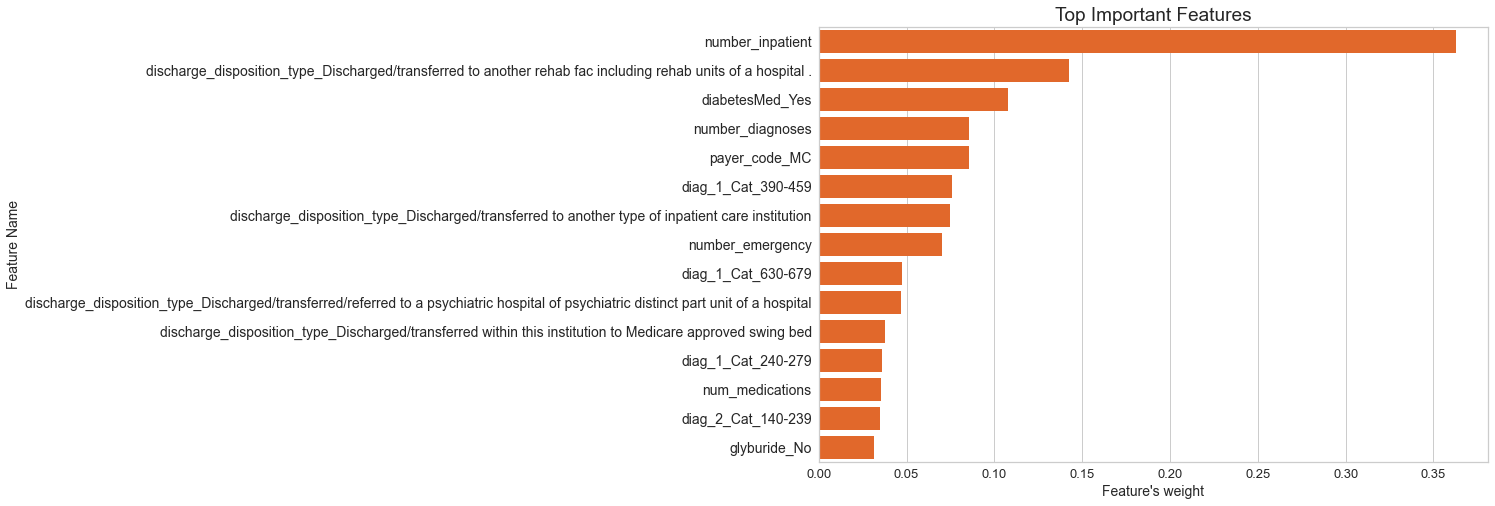

In [151]:
# Create pandas series of features weight and column names 
features_weights_pds = pd.Series(clf.coef_[0],index=X.columns)
features_weights_pds=features_weights_pds.sort_values(ascending=False)
top_ten_features = features_weights_pds.head(15).reset_index()
top_ten_features = top_ten_features.rename(columns={'index':'features',0:'weights'})
top_ten_features

plt.figure(figsize=(12,8))
sns.barplot(y='features',x='weights',data=top_ten_features,color='#FF5E0D')
plt.title('Top Important Features',size=19)
plt.ylabel('Feature Name',size=14)
plt.xlabel("Feature's weight",size=14)
plt.xticks(size=13)
plt.yticks(size=14)
plt.show() 

### Logistic Regression Iteration 3 - Penalty L2 and scaled

In [75]:
model_scaled_l2 = linear_model.LogisticRegressionCV(penalty="l2", solver='lbfgs', random_state=1234, cv=5)
model_scaled_l2 = model_scaled_l2.fit(X_train, y_train)

In [76]:
model_scaled_l2.score(X_train, y_train)

0.8884562472362797

In [77]:
model_scaled_l2.scores_

{1: array([[0.88865688, 0.88920961, 0.88951667, 0.88939385, 0.88939385,
         0.88939385, 0.88927102, 0.88939385, 0.88927102, 0.88927102],
        [0.88834981, 0.8882884 , 0.88816557, 0.88810416, 0.88804274,
         0.8882884 , 0.88810416, 0.88810416, 0.88810416, 0.88810416],
        [0.88840437, 0.88772878, 0.88760595, 0.88760595, 0.88760595,
         0.88760595, 0.88760595, 0.88760595, 0.88760595, 0.88760595],
        [0.88797445, 0.88736028, 0.88766736, 0.88754453, 0.88760595,
         0.88760595, 0.88754453, 0.88754453, 0.88754453, 0.88754453],
        [0.88858863, 0.88858863, 0.88834296, 0.88846579, 0.88840437,
         0.88840437, 0.88834296, 0.88834296, 0.88834296, 0.88834296]])}

In [78]:
model_scaled_l2.C_

array([0.0001])

<font style="color:#7B1FA2;font-weight:600">Best C is 0.0001</font>

In [79]:
y_model_scaled_l2_predict = model_scaled_l2.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_scaled_l2_predict)
print('Logistic Regression Iteration 3 - Penalty L2 and scaled and balanced": ', accuracy)

Logistic Regression Iteration 3 - Penalty L2 and scaled and balanced":  0.8883266188464184


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 3 - Penalty L2 and scaled Data is 88.83 % </font>

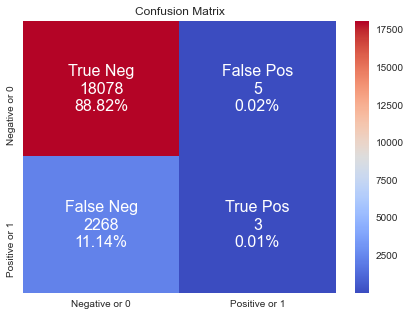

In [80]:
plot_confusion_matrix(y_test, y_model_scaled_l2_predict)

LR ROC: 0.5005222505851669


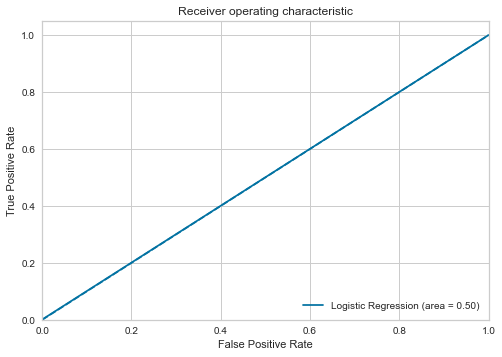

In [81]:
plot_roc_curve(y_test, y_model_scaled_l2_predict)

<br/><br/>

### Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced

In [132]:
model_scaled_l2_balanced = linear_model.LogisticRegressionCV(penalty="l2", solver='lbfgs', 
                                                             random_state=1234, cv=5, class_weight='balanced')
model_scaled_l2_balanced = model_scaled_l2_balanced.fit(X_train, y_train)

In [133]:
model_scaled_l2_balanced.score(X_train, y_train)

0.671805139291505

In [134]:
model_scaled_l2_balanced.scores_

{1: array([[0.66947123, 0.66885709, 0.66658478, 0.66603206, 0.66584782,
         0.66597064, 0.66615489, 0.66615489, 0.66597064, 0.66603206],
        [0.66468096, 0.66640054, 0.66584782, 0.66480378, 0.6648652 ,
         0.66455813, 0.66461954, 0.66455813, 0.66455813, 0.66455813],
        [0.67436433, 0.6725218 , 0.67049503, 0.67092495, 0.67135487,
         0.67172338, 0.67129345, 0.67129345, 0.67123204, 0.67123204],
        [0.66380052, 0.66631863, 0.66459894, 0.66380052, 0.66349343,
         0.66398477, 0.66392335, 0.66380052, 0.66367768, 0.66367768],
        [0.66595013, 0.66914384, 0.66895959, 0.66859108, 0.66803832,
         0.66797691, 0.66791549, 0.66809974, 0.66803832, 0.66803832]])}

In [135]:
model_scaled_l2_balanced.C_

array([0.00077426])

#### Best C is 0.00077426

In [136]:
model_scaled_l2_balanced = linear_model.LogisticRegressionCV(Cs=[model_scaled_l2_balanced.C_], penalty="l2", solver='lbfgs', 
                                                             random_state=1234, cv=5, class_weight='balanced')
model_scaled_l2_balanced = model_scaled_l2_balanced.fit(X_train, y_train)

In [137]:
y_model_scaled_l2_balanced_predict = model_scaled_l2_balanced.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_scaled_l2_balanced_predict)
print('Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced": ', accuracy)

Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced":  0.6713668075071239


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced Data is 67.14 % </font>

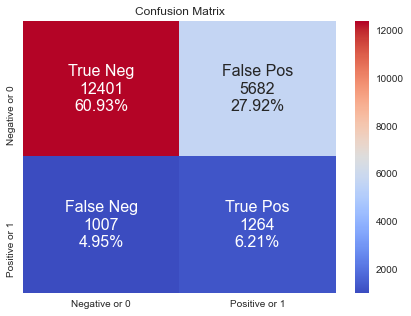

In [138]:
plot_confusion_matrix(y_test, y_model_scaled_l2_balanced_predict)

LR ROC: 0.6211826147414147


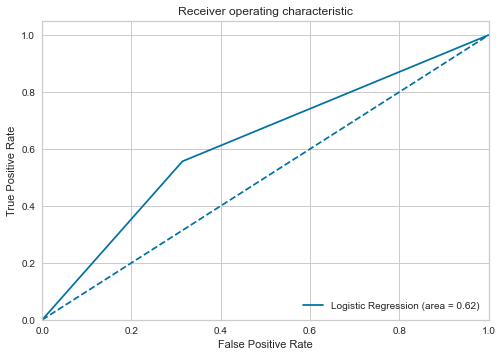

In [139]:
plot_roc_curve(y_test, y_model_scaled_l2_balanced_predict)

##### Precision Recall F1 Score 

<br/><br/>

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.21')

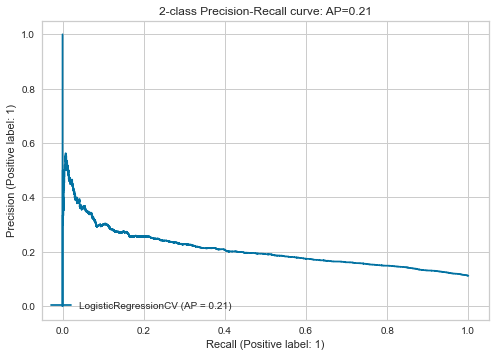

In [157]:
y_score = model_scaled_l2_balanced.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
disp = plot_precision_recall_curve(model_scaled_l2_balanced, X_test, y_test)

disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

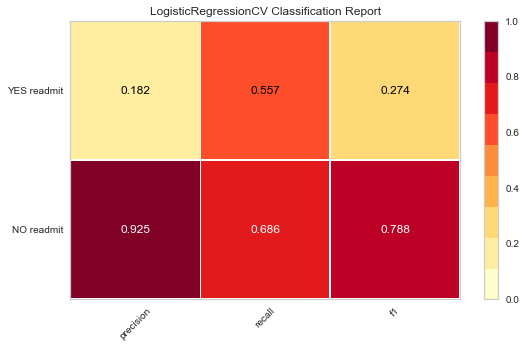

In [158]:
classes = ['NO readmit', 'YES readmit']
visualizer = ClassificationReport(model_scaled_l2_balanced,classes=classes)
plt.figure(figsize=(8,5))
plt.title('Precision-Recall-F1 Score')
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 

g = visualizer.poof()

### Logistic Regression Iteration 5 - Penalty L2, scaled and upsampled using SMOTE

#### Using imblearn.over_sampling SMOTE for over sampling unbalanced data

Total Records 144652
Total Classes: 2
Class Gini Index 0.5
Smallest Class Id: 1 Records: 72326
Largest Class Id: 1 Records: 72326
Accuracy when Guessing: 50.0 %


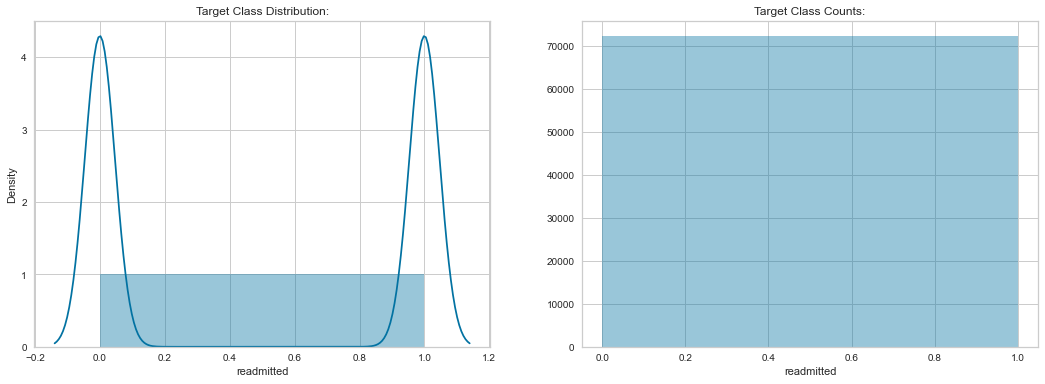

In [90]:
sm = SMOTE(random_state=1234)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

plot_class_dist(y_sm)

#### Model building

In [91]:
model_scaled_l2_SMOTE = linear_model.LogisticRegressionCV(penalty="l2", solver='lbfgs', random_state=1234, cv=5)
model_scaled_l2_SMOTE = model_scaled_l2_SMOTE.fit(X_sm, y_sm)

In [92]:
model_scaled_l2_SMOTE.score(X_sm, y_sm)

0.6481624865193706

In [93]:
model_scaled_l2_SMOTE.scores_

{1: array([[0.62362172, 0.62427846, 0.62420933, 0.62486606, 0.62458954,
         0.62462411, 0.62465867, 0.62479693, 0.6247278 , 0.62469324],
        [0.64868135, 0.64774809, 0.64830113, 0.648232  , 0.64826657,
         0.64864678, 0.64850852, 0.64864678, 0.64861222, 0.64864678],
        [0.65164189, 0.65181473, 0.65250605, 0.65240235, 0.65309367,
         0.65305911, 0.65302454, 0.65316281, 0.65323194, 0.65319737],
        [0.64911856, 0.64942966, 0.64984445, 0.65001728, 0.65032838,
         0.65032838, 0.65039751, 0.65029381, 0.65032838, 0.65019011],
        [0.64849637, 0.6513308 , 0.65278258, 0.65302454, 0.65326651,
         0.65316281, 0.65309367, 0.65302454, 0.65305911, 0.65305911]])}

In [94]:
model_scaled_l2_SMOTE.C_

array([1291.54966501])

#### Best C is 1291.54966

In [95]:
model_scaled_l2_SMOTE = linear_model.LogisticRegressionCV(Cs=[1291.54966501], penalty="l2", solver='lbfgs', random_state=1234, max_iter=10000)
model_scaled_l2_SMOTE = model_scaled_l2_SMOTE.fit(X_sm, y_sm)

In [96]:
y_model_scaled_l2_SMOTE_predict = model_scaled_l2_SMOTE.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_scaled_l2_SMOTE_predict)
print('Logistic Regression Iteration 6 - Penalty L2, scaled and upsampled using SMOTE": ', accuracy)

Logistic Regression Iteration 6 - Penalty L2, scaled and upsampled using SMOTE":  0.6468998722609807


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 6 - Penalty L2, scaled and upsampled using SMOTE 64.7 % </font>

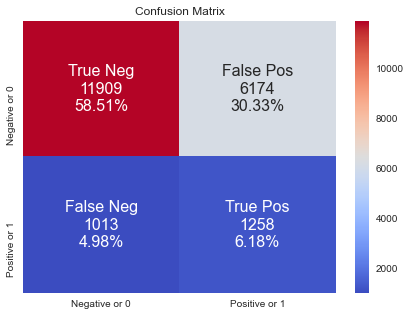

In [97]:
plot_confusion_matrix(y_test, y_model_scaled_l2_SMOTE_predict)

LR ROC: 0.606257673378635


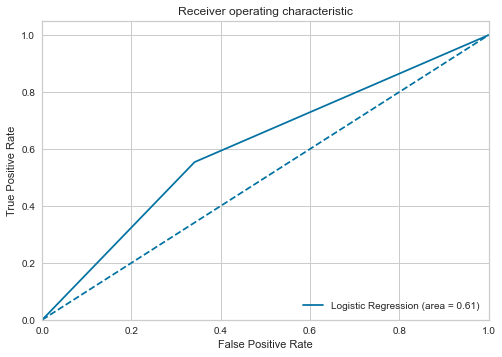

In [98]:
plot_roc_curve(y_test, y_model_scaled_l2_SMOTE_predict)

<br/>
<br/>
<br/>

<font style="color:#7B1FA2;font-weight:600;font-size:18px">Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced considered to be best so far. We shall perform further analysis on this model</font>

#### Get important features 

#### Feature Importance for L2 model

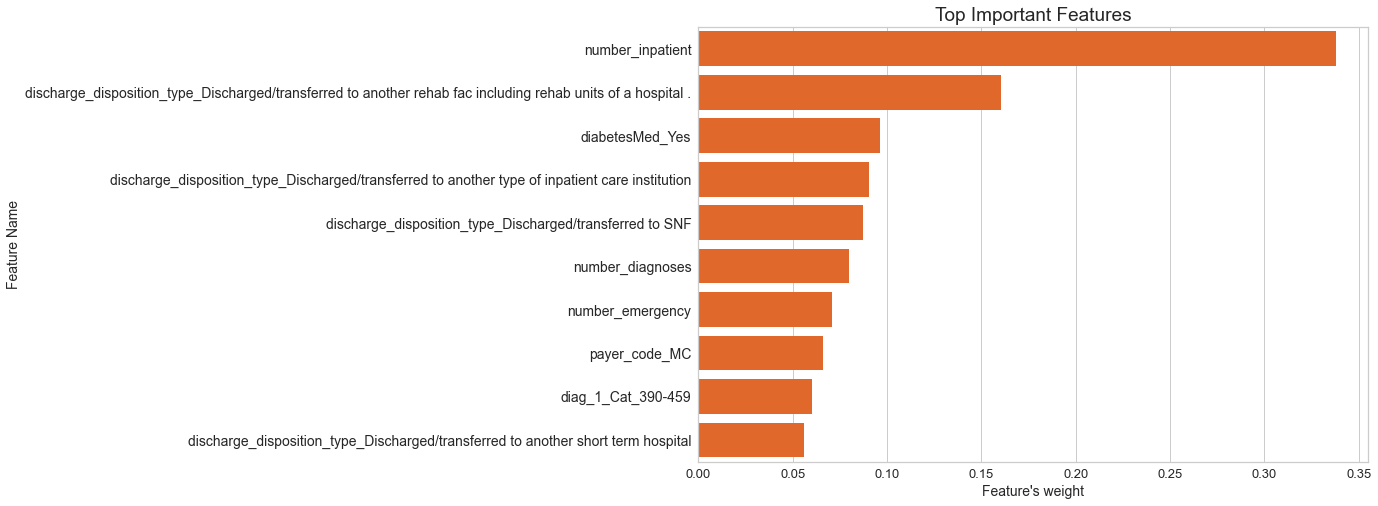

In [156]:
# Create pandas series of features weight and column names 
l2_features_weights_pds = pd.Series(model_scaled_l2_balanced.coef_[0],index=X.columns)

l2_features_weights_pds=l2_features_weights_pds.sort_values(ascending=False)
l2_top_ten_features = l2_features_weights_pds.head(10).reset_index()
l2_top_ten_features = l2_top_ten_features.rename(columns={'index':'features',0:'weights'})
l2_top_ten_features

plt.figure(figsize=(12,8))
sns.barplot(y='features',x='weights',data=l2_top_ten_features,color='#FF5E0D')
plt.title('Top Important Features',size=19)
plt.ylabel('Feature Name',size=14)
plt.xlabel("Feature's weight",size=14)
plt.xticks(size=13)
plt.yticks(size=14)
plt.show()


### Interpretation

As we can see from isolating the ten attributes with the highest weights, 'number_of_inpatient' has the higest weight followed by 'discharge_disposition_type_Discharged/transferred to another rehab fac including rehab units of a hospital' and 'diabetesMed_Yes' etc.

###  PCA - Dimensionality reduction 

In [146]:
# PCA
### Dimensionality reduction 

pca_model = linear_model.LogisticRegression(class_weight='balanced')
pca = PCA(n_components=6)
x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(X_test)

print("Explained Variance Ratio: ", pca.explained_variance_ratio_)

scores_acc_pca = cross_val_score(pca_model,x_train_pca, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores_acc_pca

model_scaled_l2_balanced_pca.fit(x_train_pca,y_train)
model_scaled_l2_balanced_pca.score(x_test_pca,y_test)

y_hat=model_scaled_l2_balanced_pca.predict(x_test_pca)

Explained Variance Ratio:  [0.01427006 0.01388646 0.01283242 0.01082598 0.01016642 0.00957928]


In [147]:
print("Accuracy Score: ", metrics.accuracy_score(y_test,y_hat))

print("ROC AUC Score: ", metrics.roc_auc_score(y_test,y_hat))

Accuracy Score:  0.573793848874914
ROC AUC Score:  0.5616487509659032


### Conclusion

As in any dataset understanding feature relationship with target variable and meaning missing data imputation is cumbersome and iterative process. We spend substantial amount of time in this process. Model building and choosing the best out of the researched models is another challenging task, which needs skill to build meaning models to the context within resources. We have spent remaining most of the time in this process.

We have chosen the best model as the one with scaled and balanced data, best hyperparameter C = 0.0007 and L2 regularization. This model generated a mean accuracy of 67% on training set and ROC curve and score (62%) shows it is better at predicting both majority and minority class compared.

Further, we can create hybrid features and try other classification models to compare the model accuracy and predictability.
Even though this is not the best model, 67% accuracy is considerably decent, and we can deploy into production, while we do further investigation with different classification models.


<br/><br/>